> Found 18009 images...
epoch1: avg loss_g: 14.998  avg_loss_d: 1.648
testing score: 0.12 best_test_score = 0.12
new_testing score: 0.13 best_new_test_score=0.13
---------------------------------------------
epoch2: avg loss_g: 2.245  avg_loss_d: 1.412
testing score: 0.10 best_test_score = 0.12
new_testing score: 0.10 best_new_test_score=0.13
---------------------------------------------
epoch3: avg loss_g: 2.456  avg_loss_d: 1.165
testing score: 0.07 best_test_score = 0.12
new_testing score: 0.13 best_new_test_score=0.13
---------------------------------------------
epoch4: avg loss_g: 2.657  avg_loss_d: 1.098
testing score: 0.17 best_test_score = 0.17
new_testing score: 0.10 best_new_test_score=0.13
---------------------------------------------
epoch5: avg loss_g: 2.723  avg_loss_d: 0.940
testing score: 0.14 best_test_score = 0.17
new_testing score: 0.14 best_new_test_score=0.14
---------------------------------------------
epoch6: avg loss_g: 2.664  avg_loss_d: 0.986
testing score: 

/home/frank/Desktop/HW/DLP_HW7/dataset/task_1/GAN/evaluator.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 6))


epoch22: avg loss_g: 4.841  avg_loss_d: 0.366
testing score: 0.36 best_test_score = 0.43
new_testing score: 0.38 best_new_test_score=0.49
---------------------------------------------
epoch23: avg loss_g: 4.680  avg_loss_d: 0.319
testing score: 0.39 best_test_score = 0.43
new_testing score: 0.31 best_new_test_score=0.49
---------------------------------------------
epoch24: avg loss_g: 4.896  avg_loss_d: 0.307
testing score: 0.36 best_test_score = 0.43
new_testing score: 0.32 best_new_test_score=0.49
---------------------------------------------
epoch25: avg loss_g: 4.715  avg_loss_d: 0.389
testing score: 0.42 best_test_score = 0.43
new_testing score: 0.39 best_new_test_score=0.49
---------------------------------------------
epoch26: avg loss_g: 4.838  avg_loss_d: 0.446
testing score: 0.35 best_test_score = 0.43
new_testing score: 0.37 best_new_test_score=0.49
---------------------------------------------
epoch27: avg loss_g: 4.616  avg_loss_d: 0.307
testing score: 0.35 best_test_scor

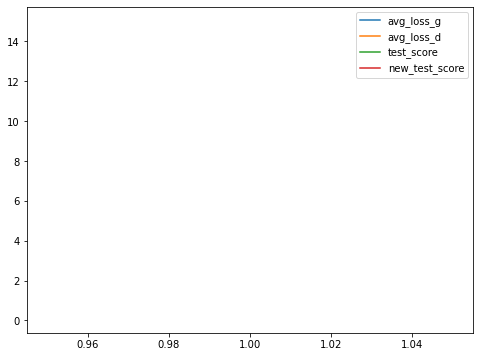

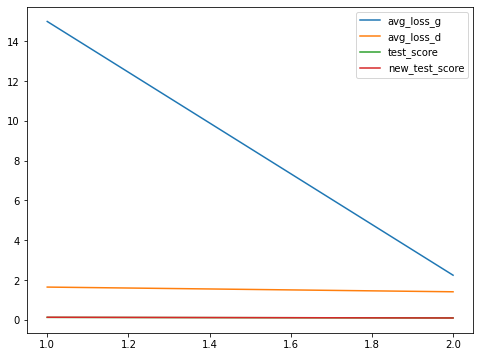

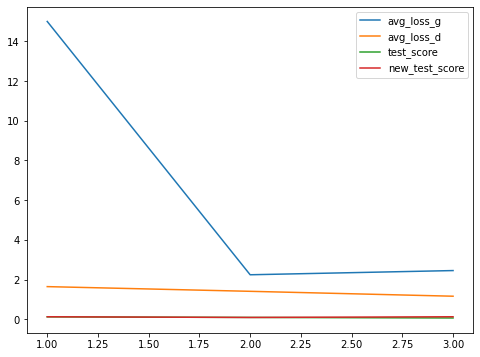

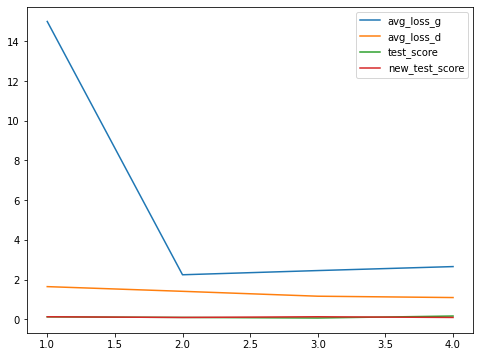

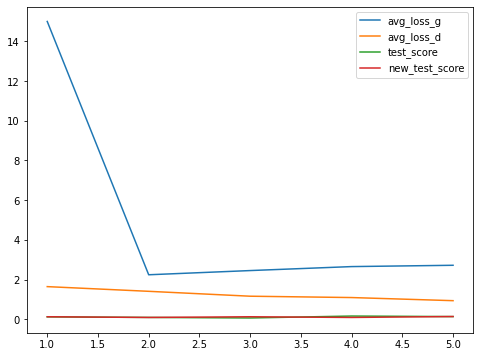

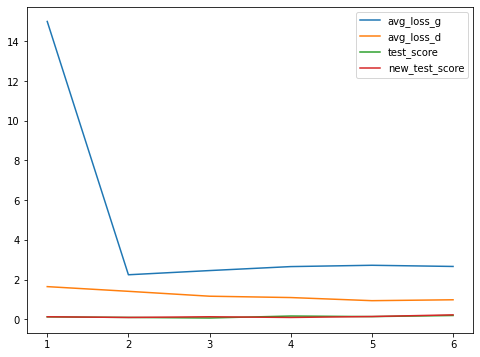

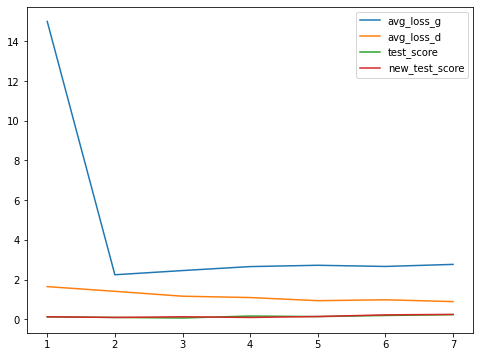

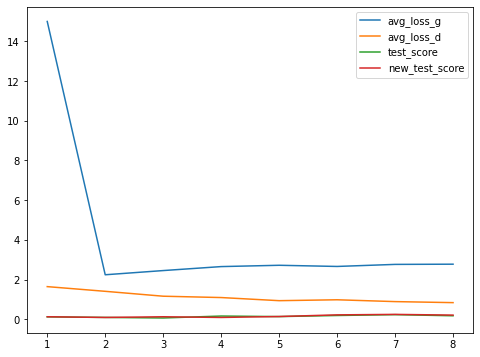

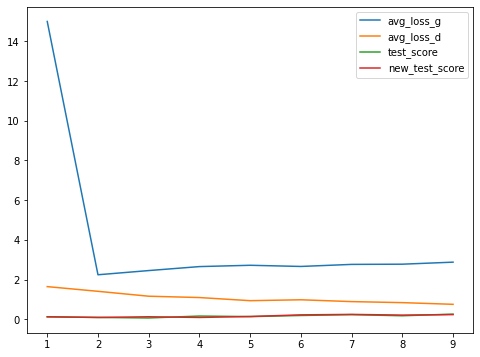

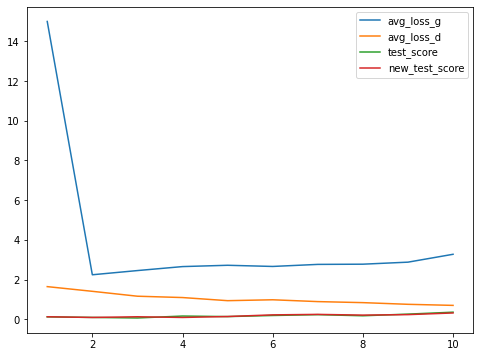

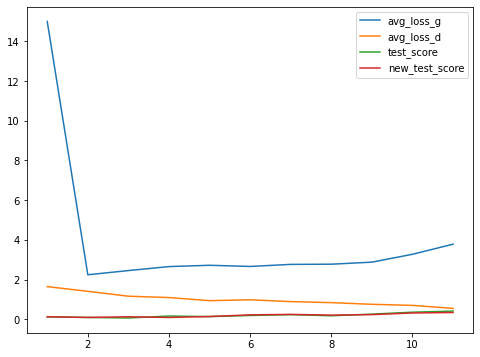

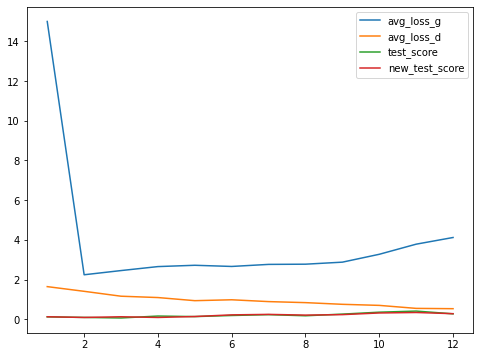

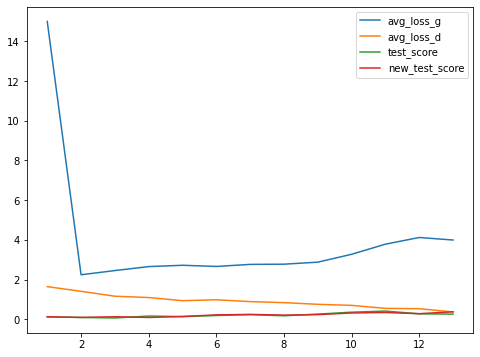

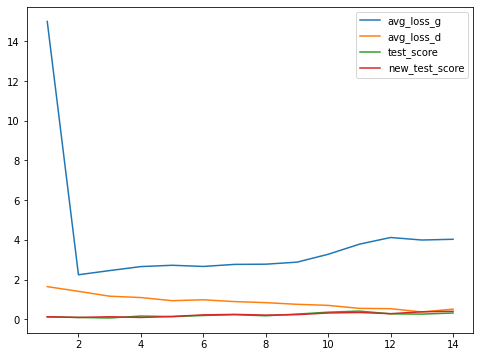

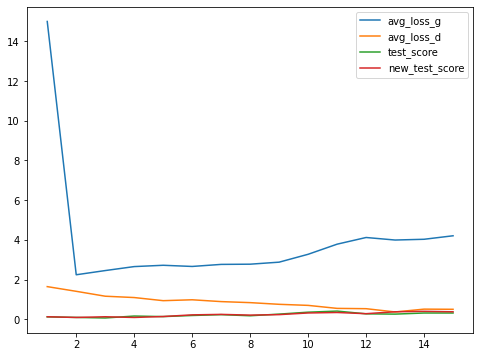

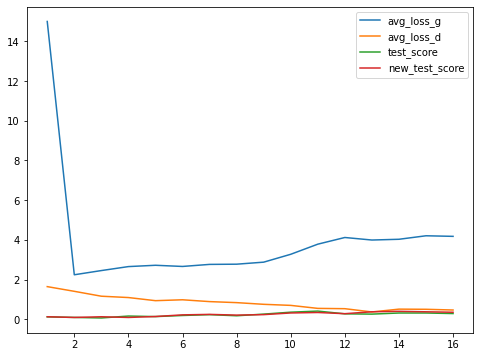

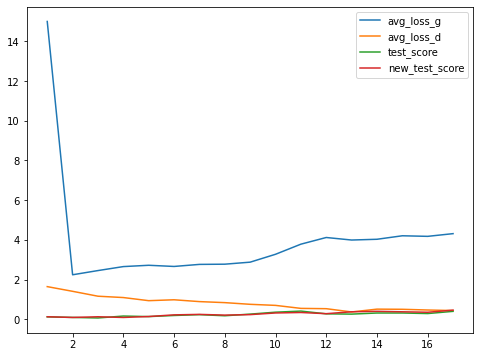

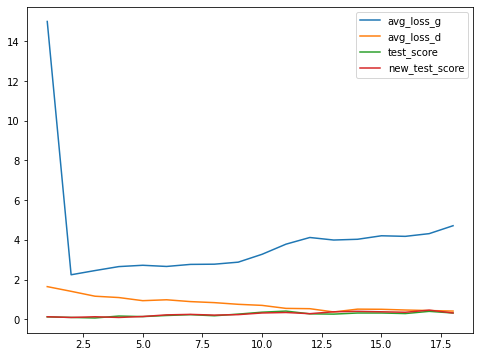

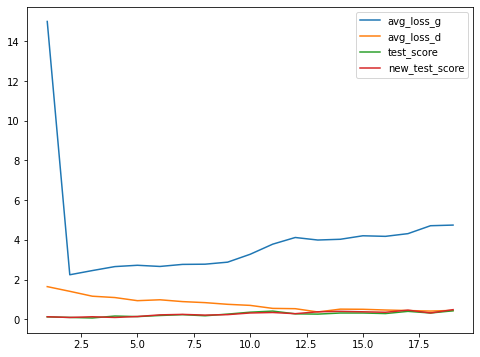

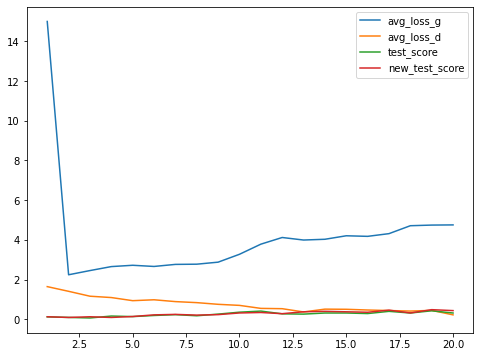

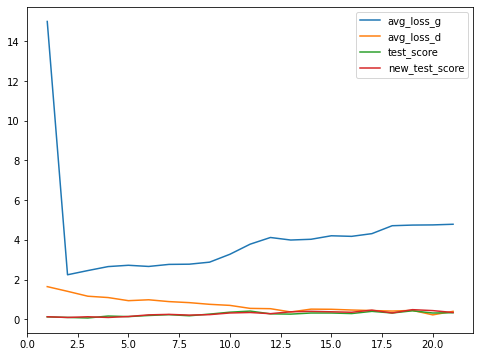

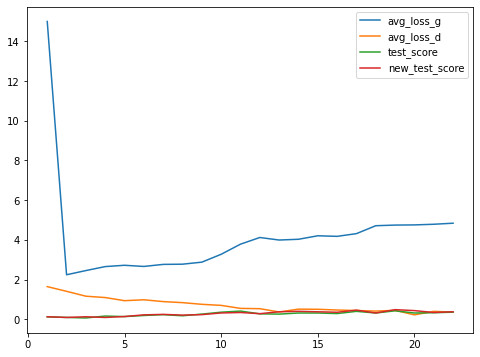

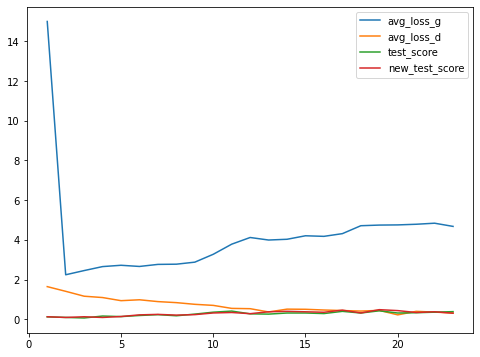

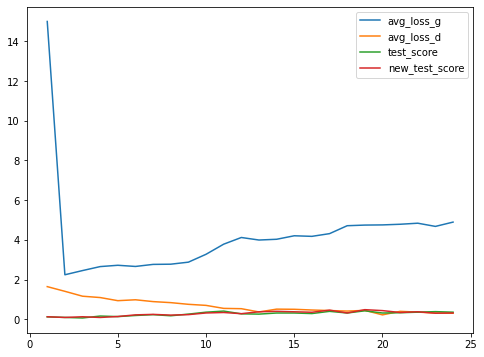

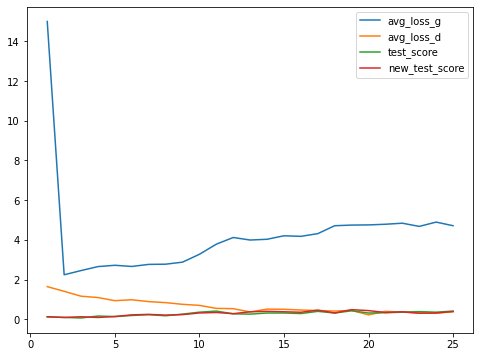

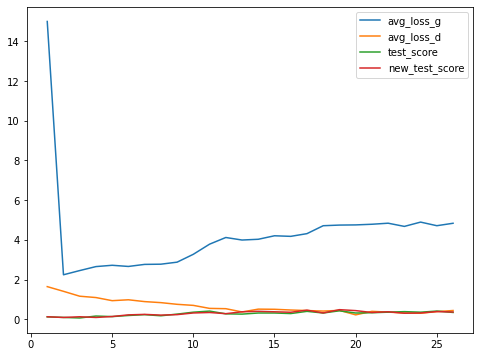

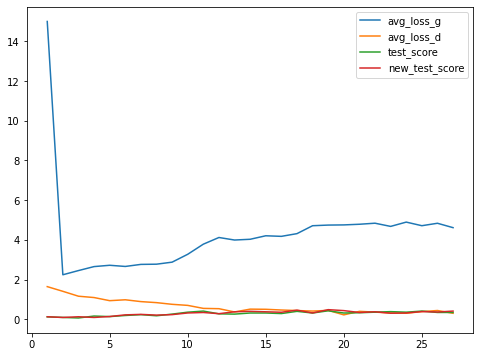

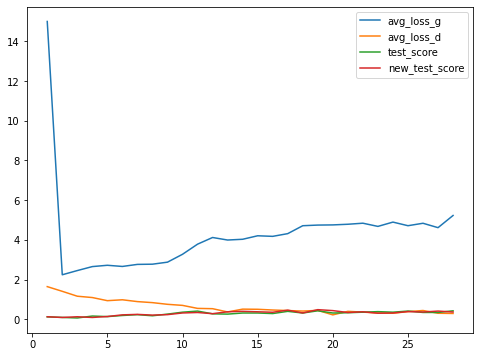

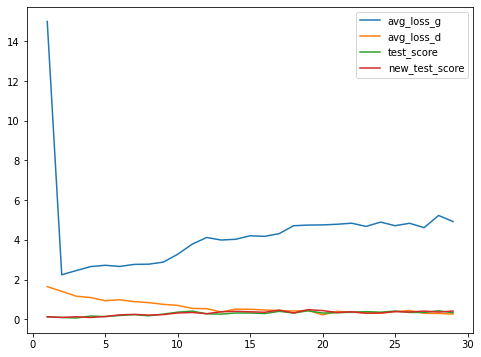

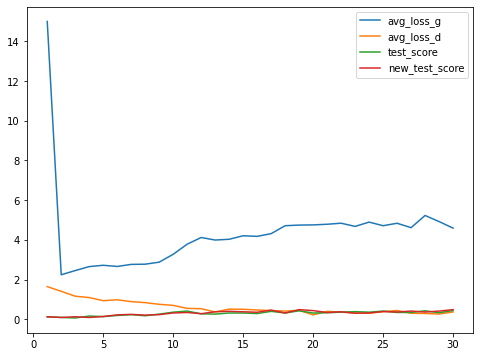

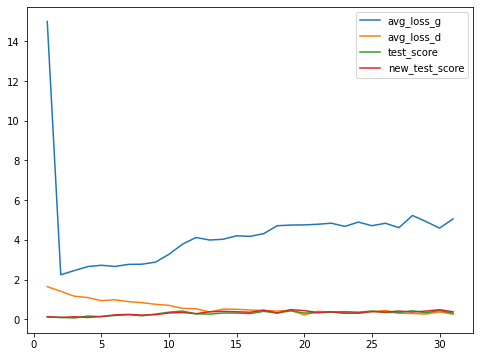

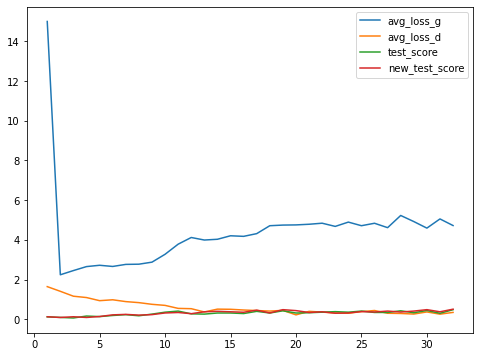

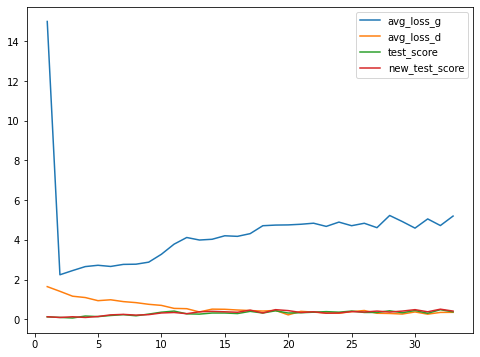

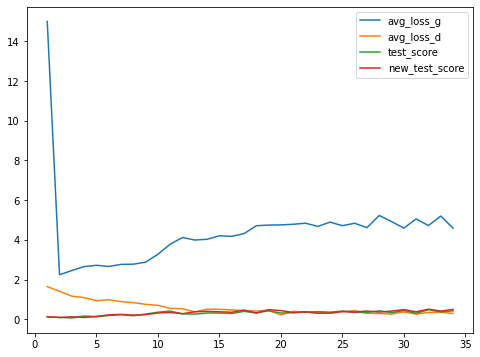

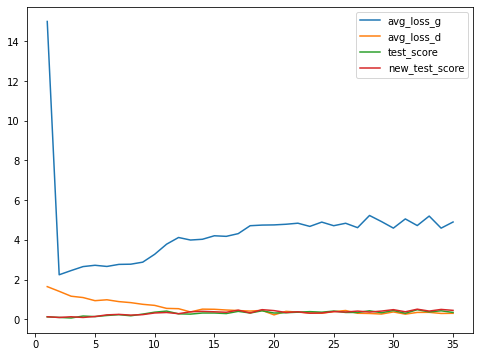

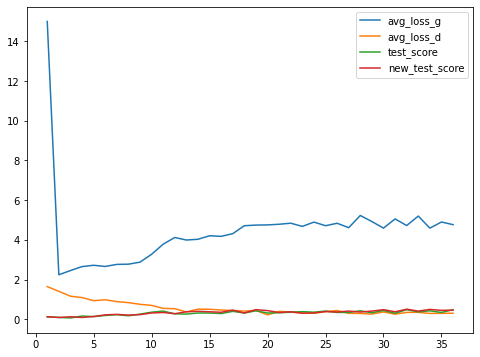

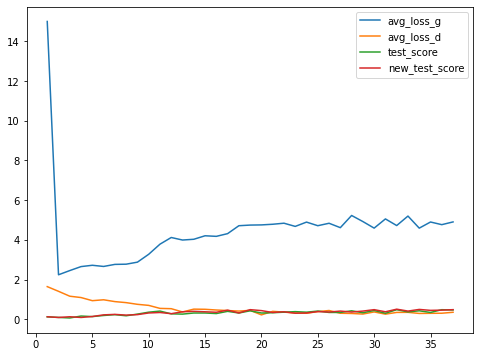

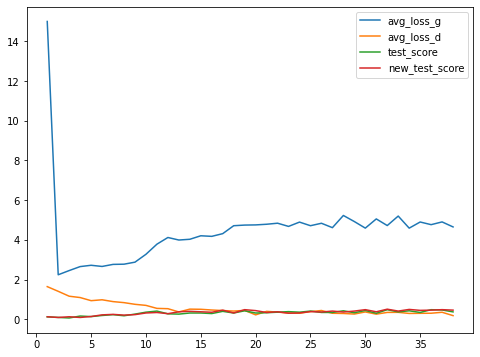

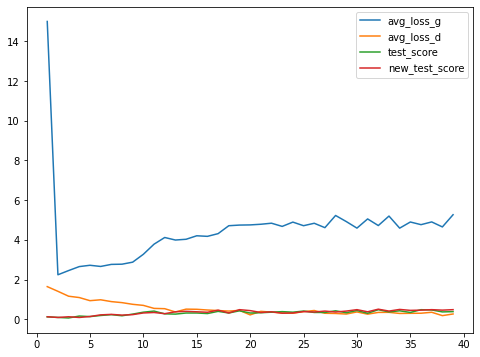

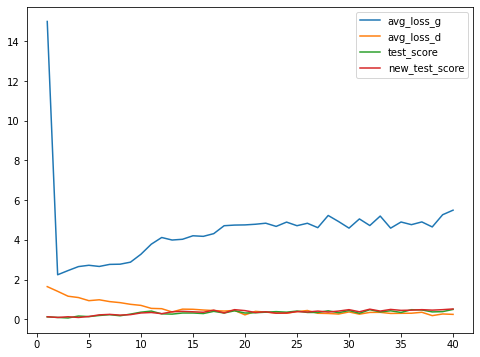

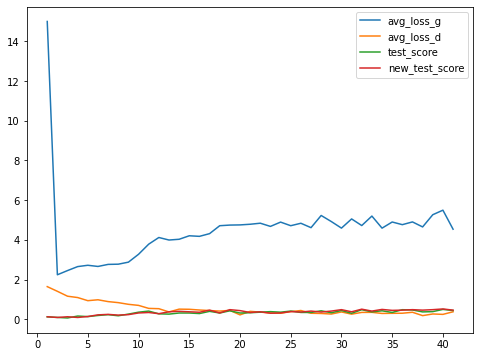

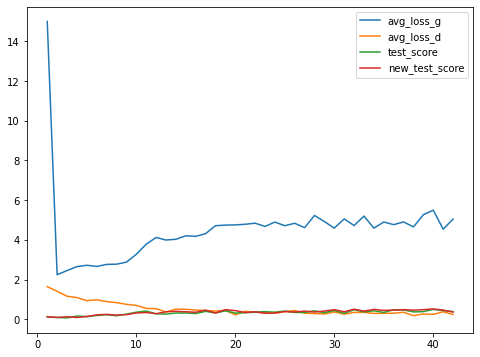

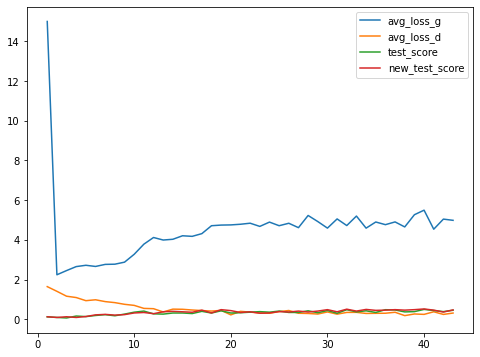

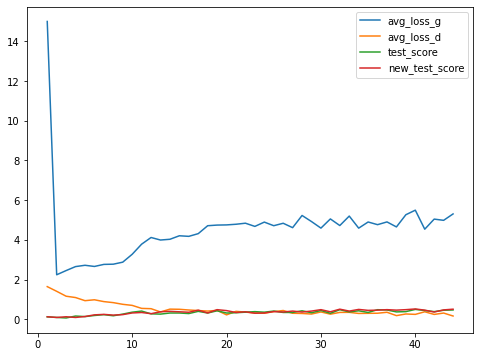

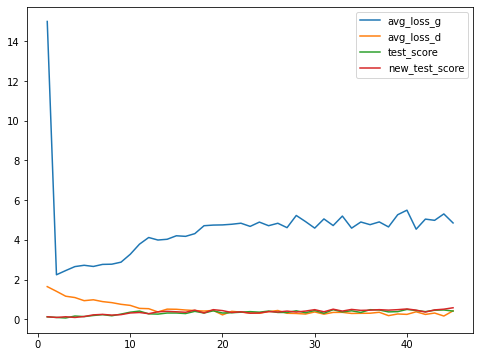

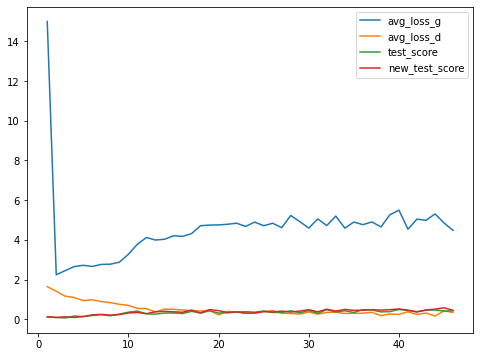

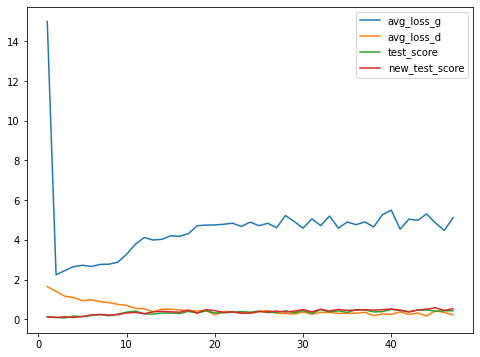

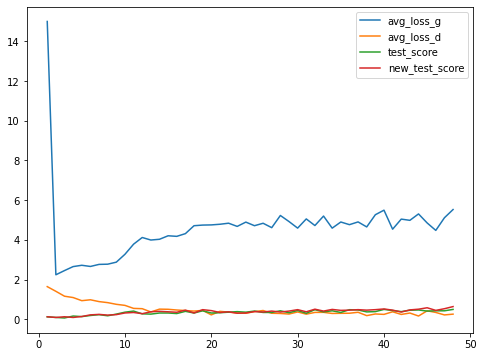

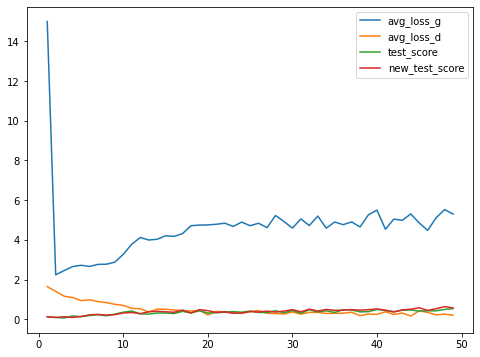

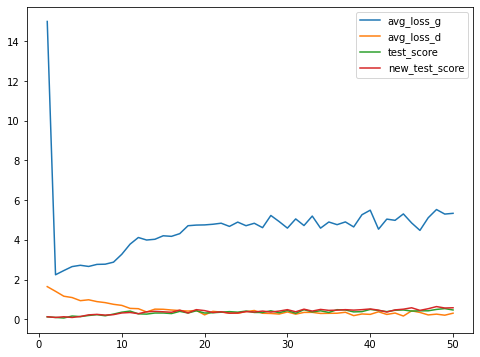

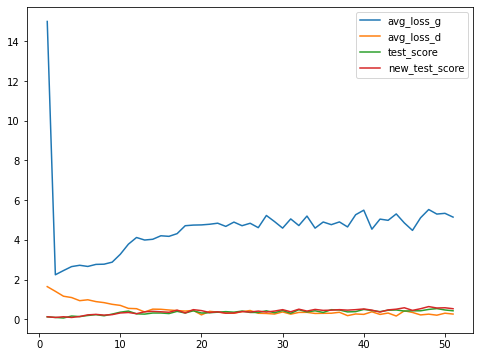

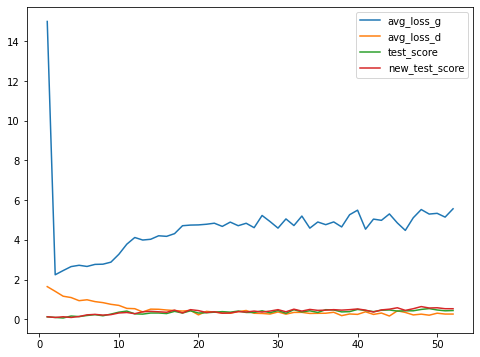

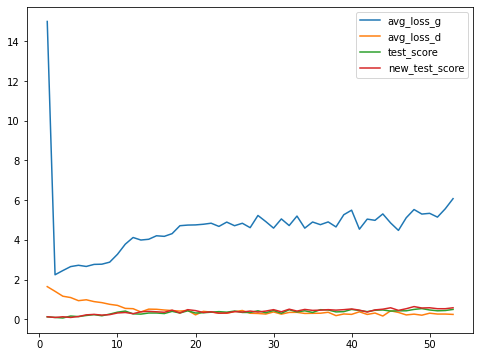

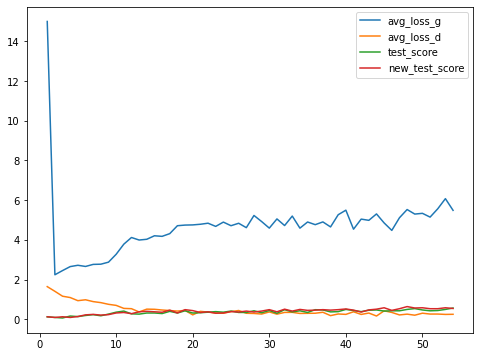

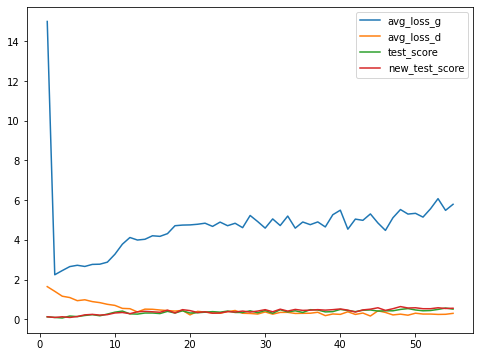

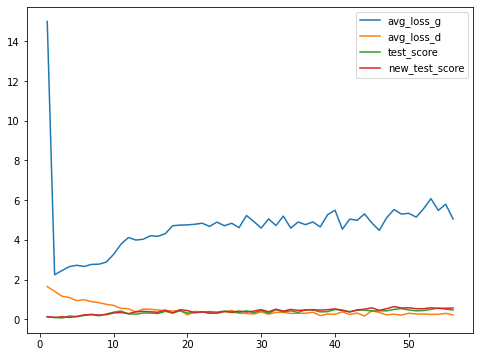

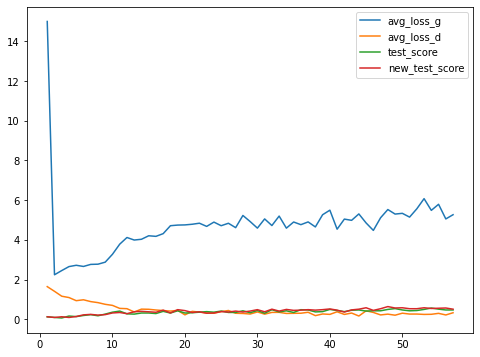

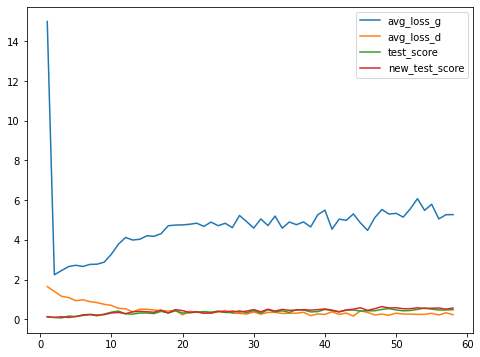

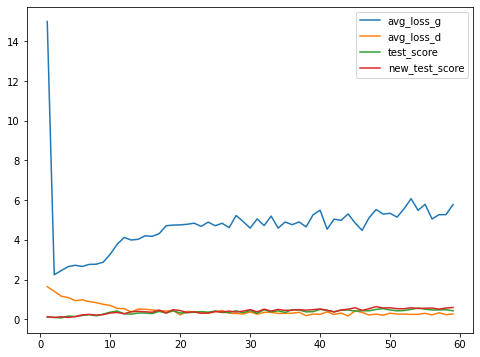

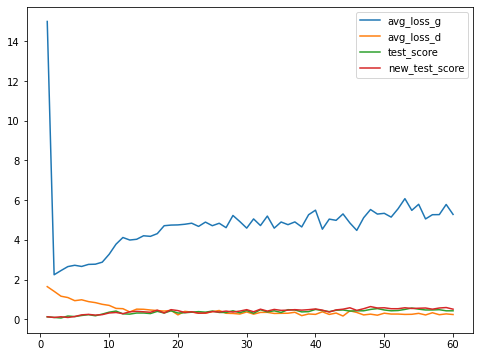

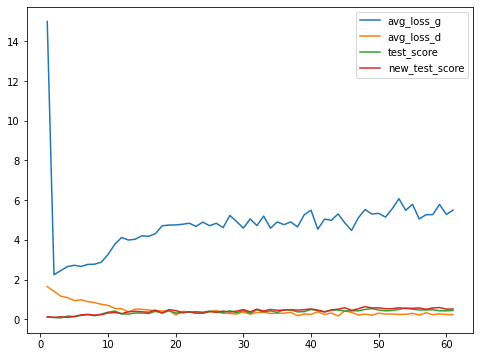

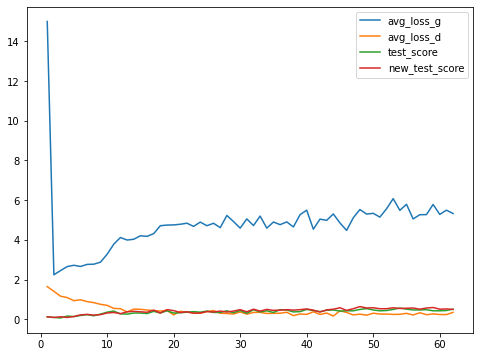

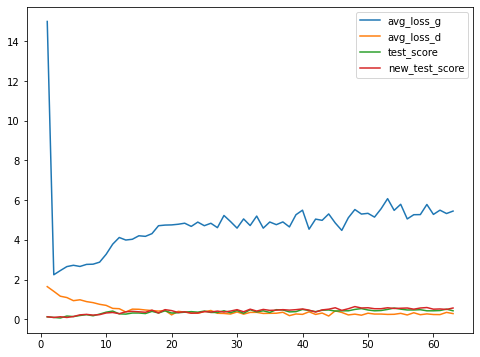

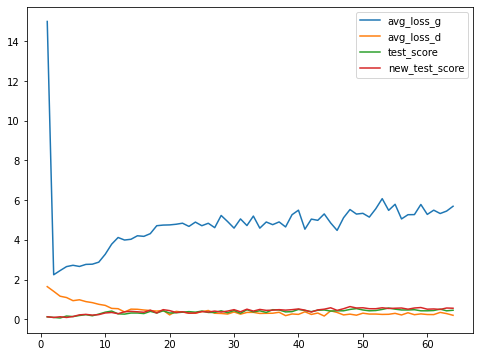

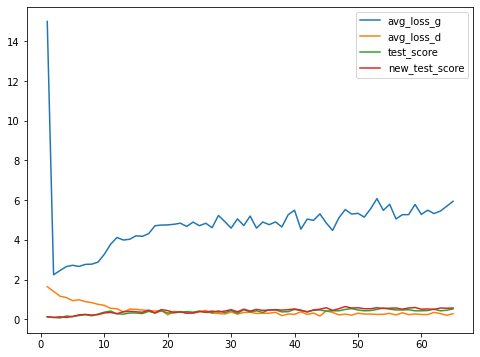

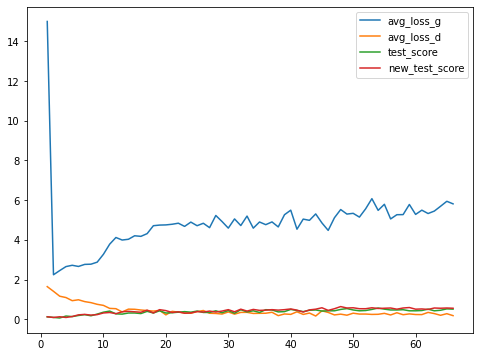

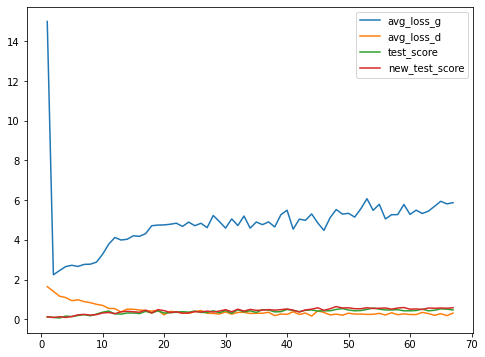

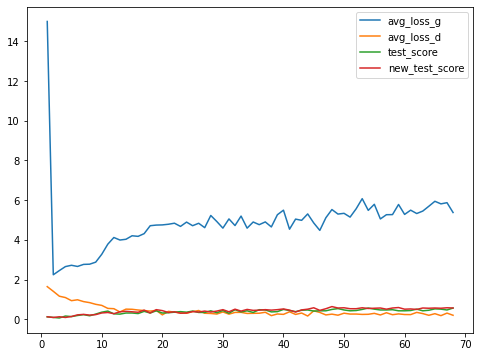

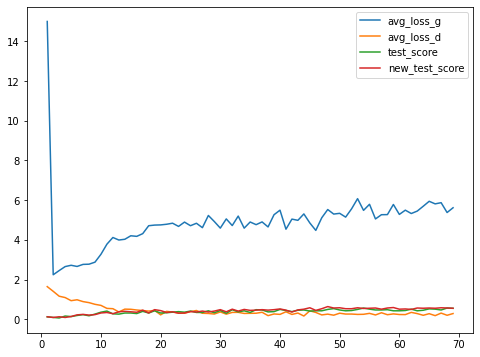

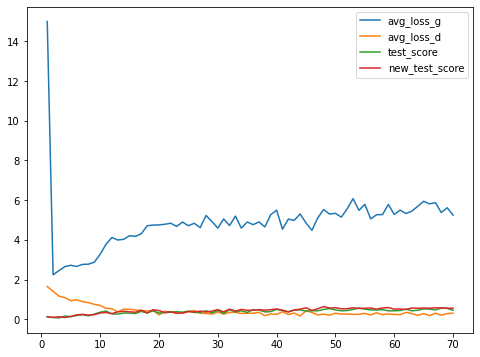

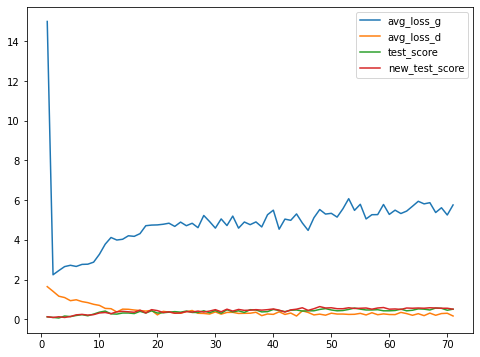

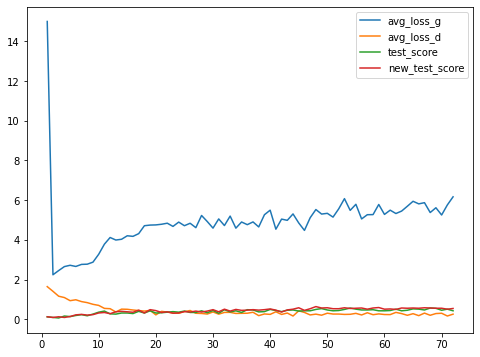

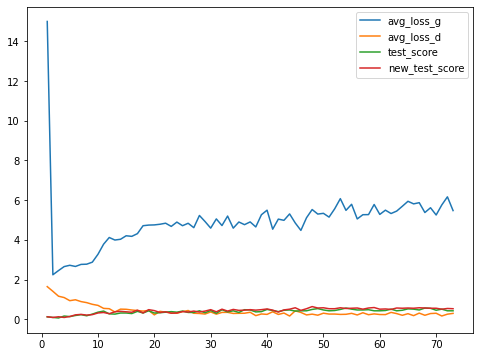

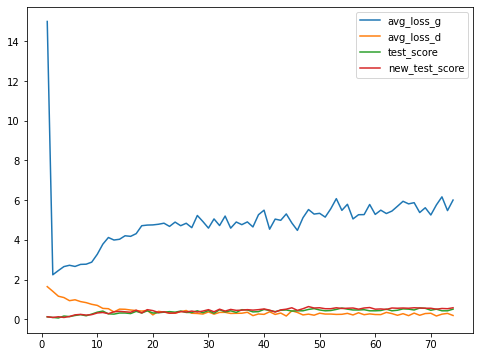

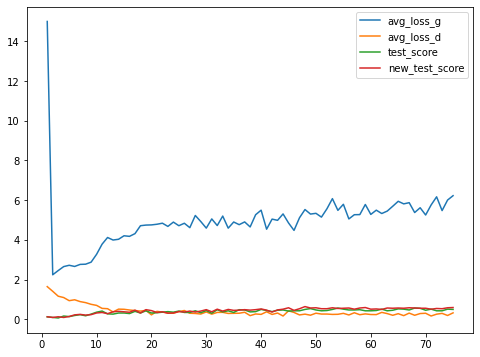

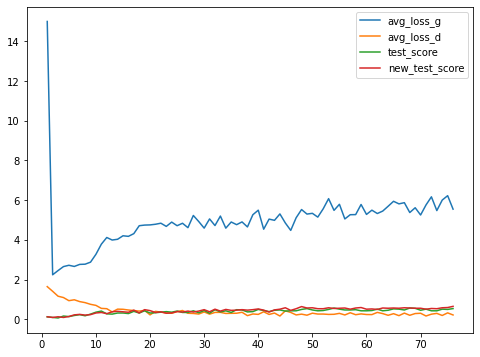

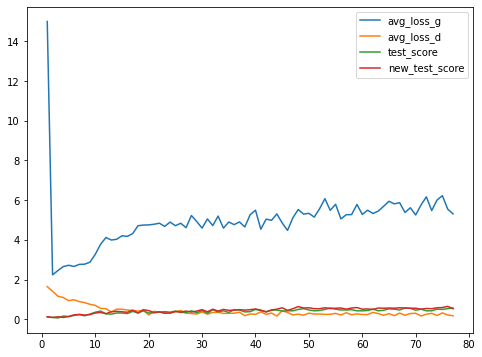

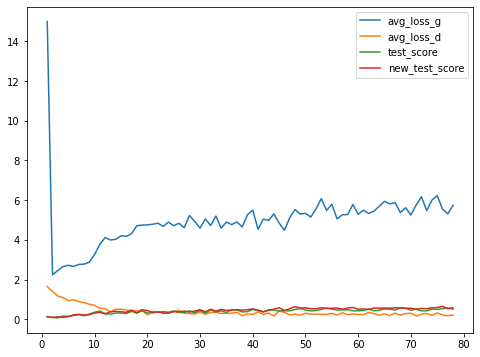

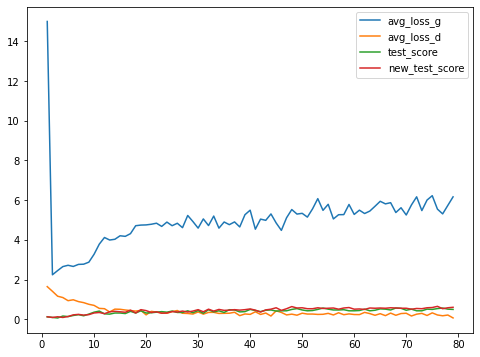

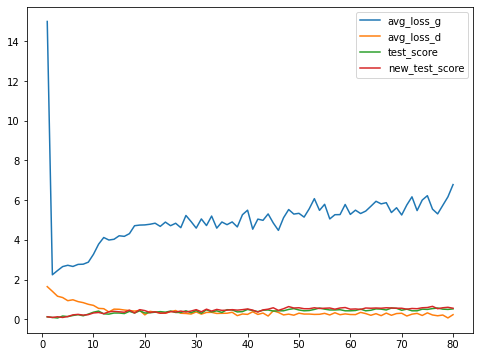

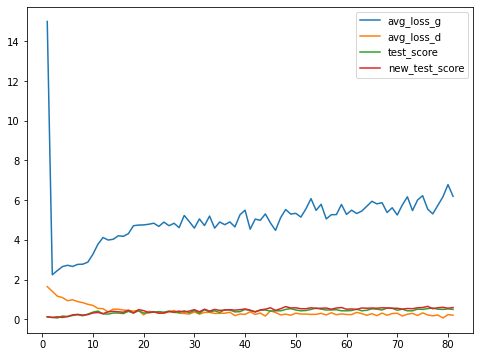

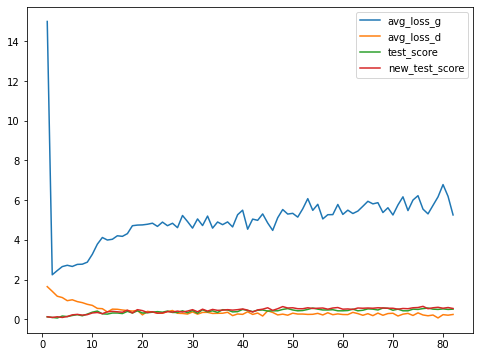

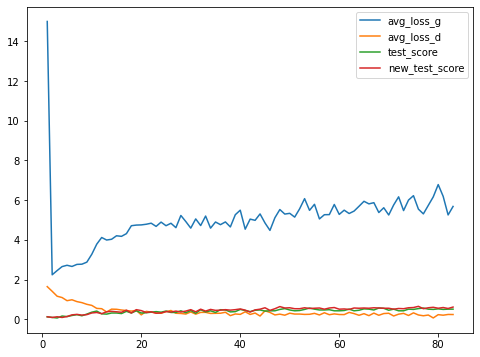

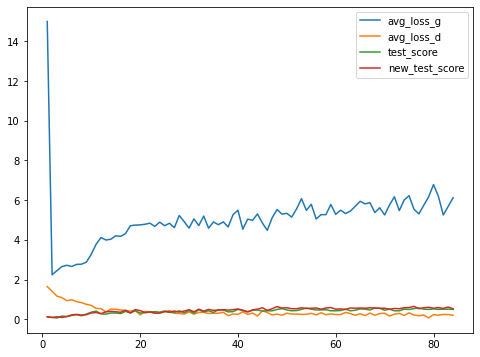

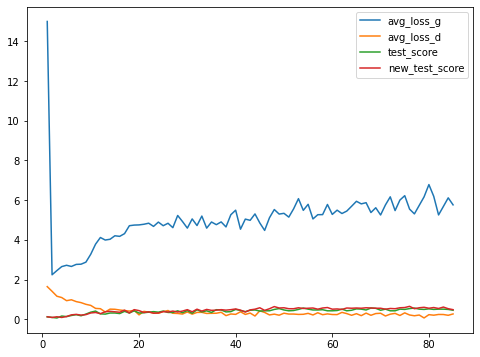

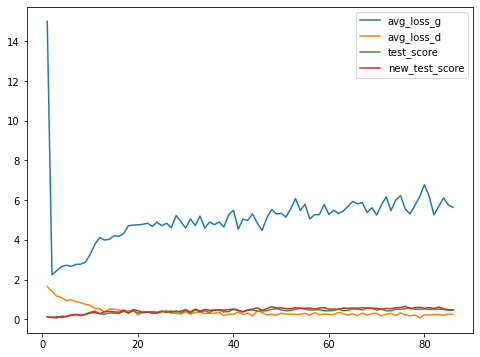

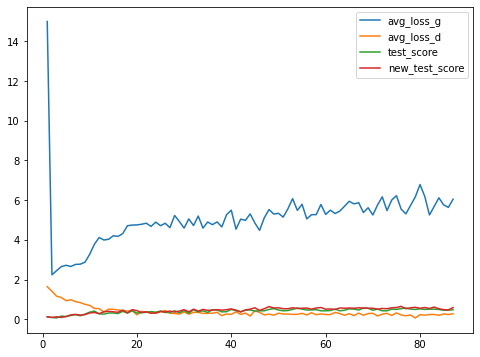

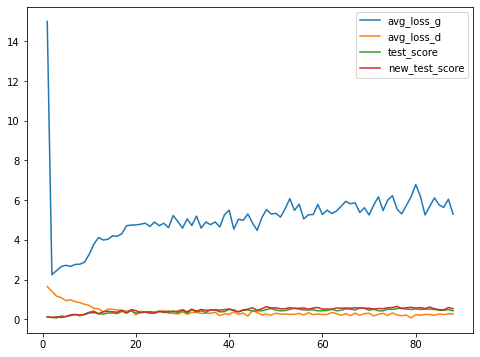

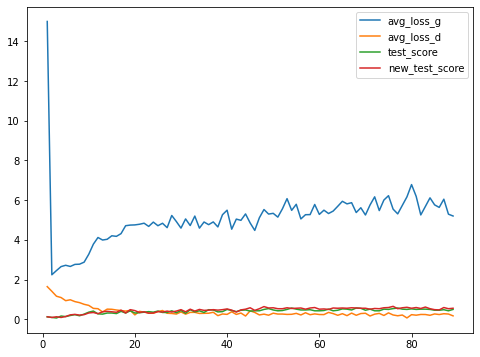

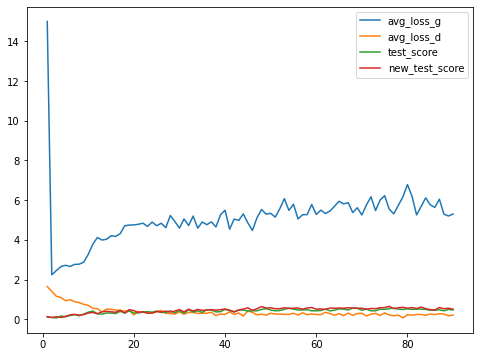

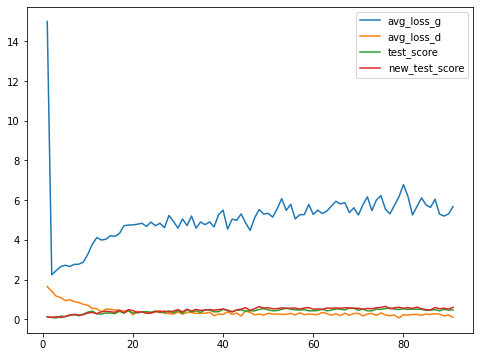

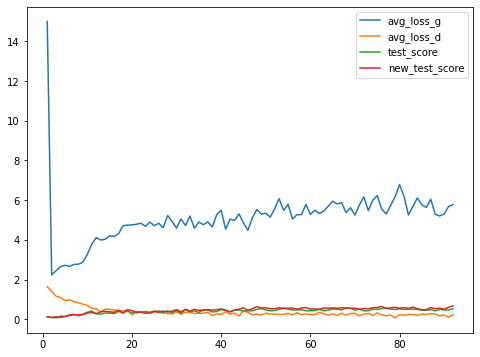

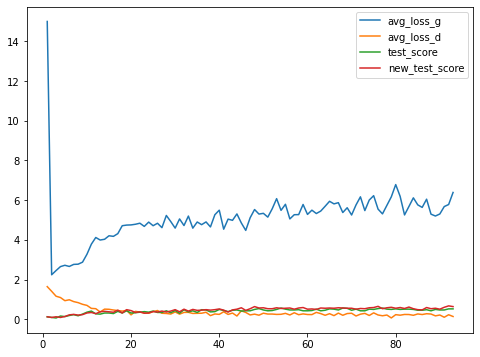

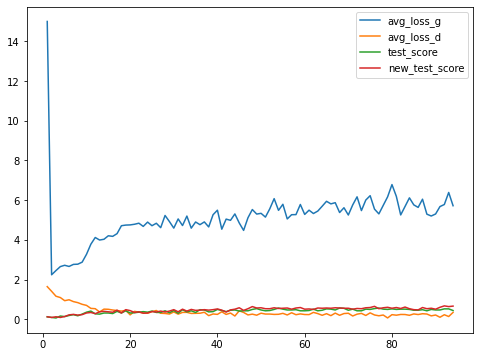

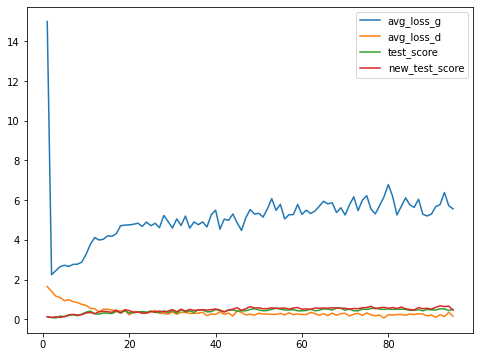

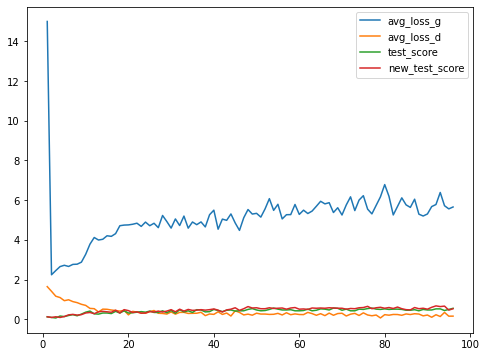

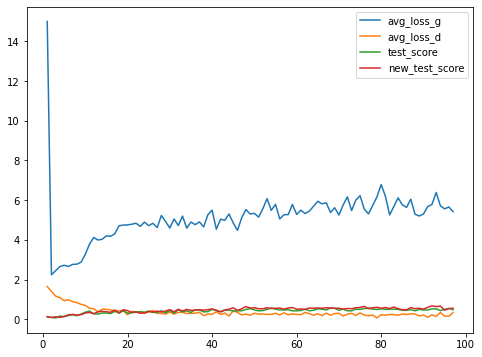

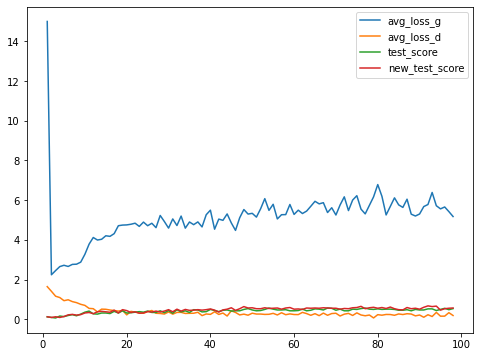

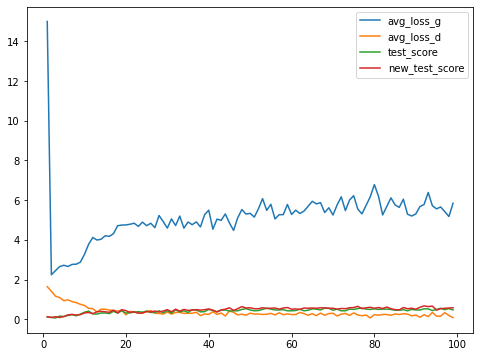

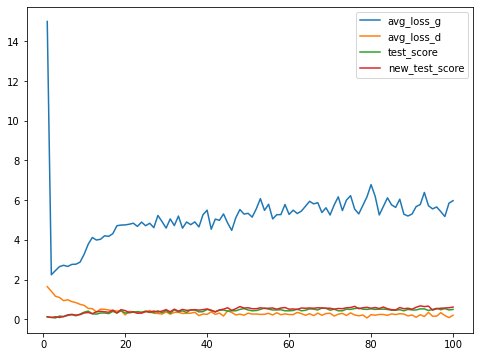

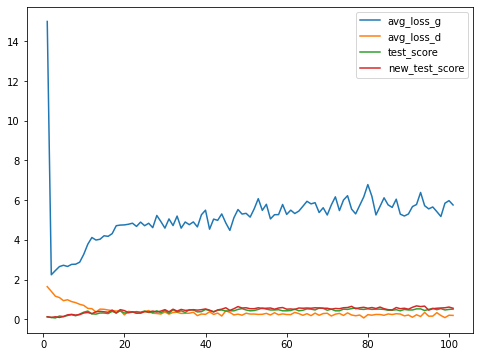

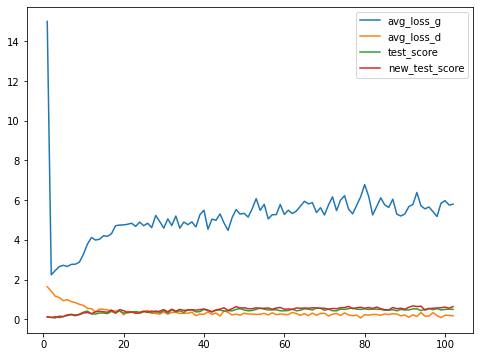

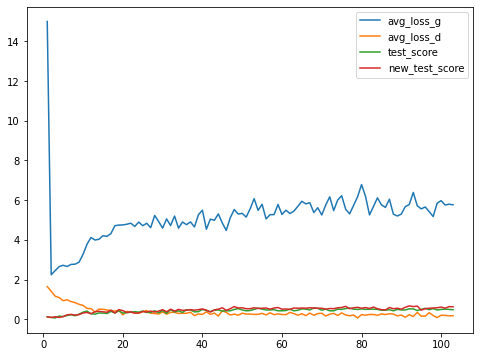

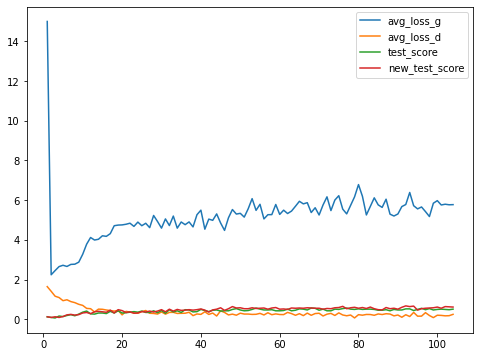

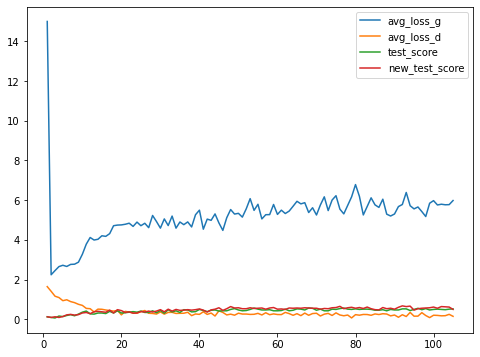

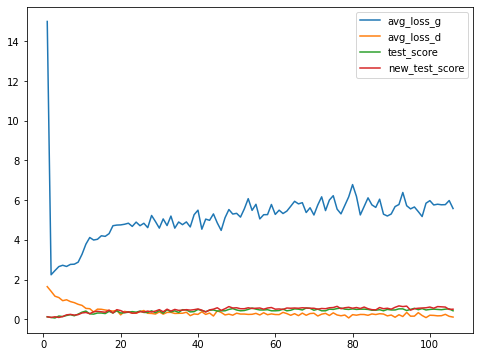

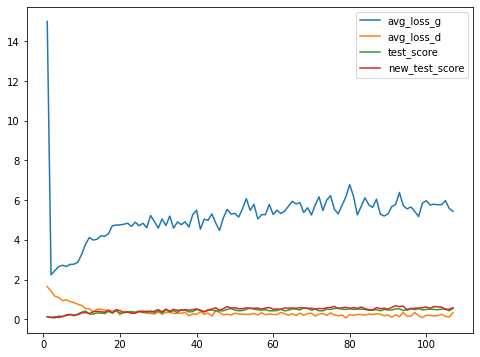

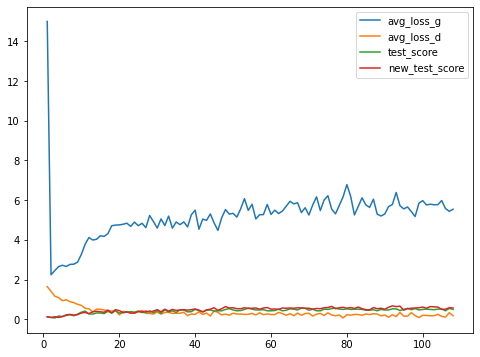

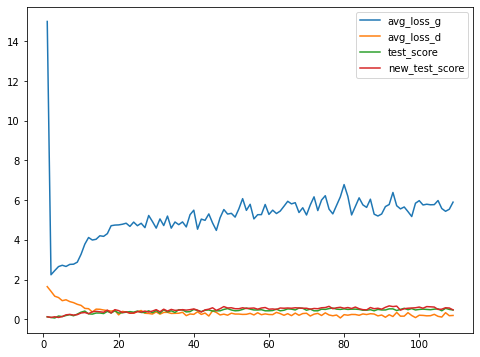

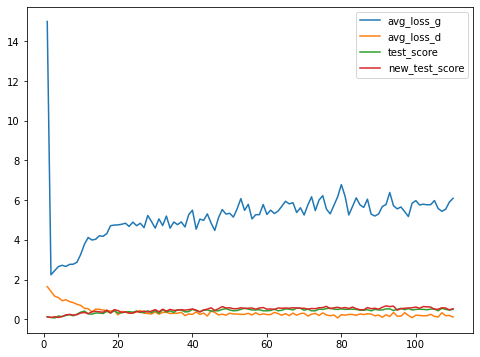

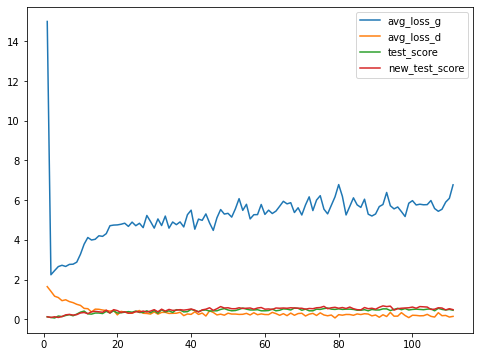

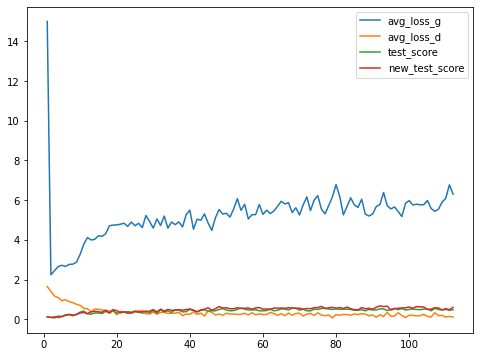

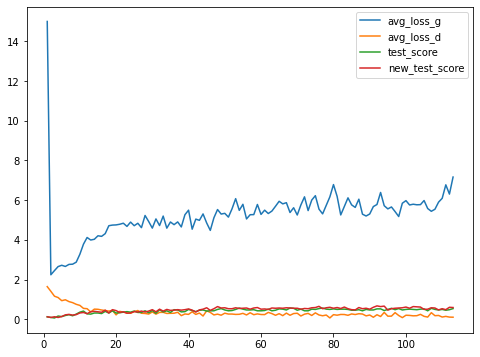

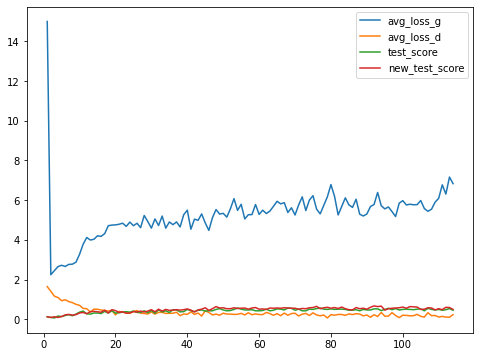

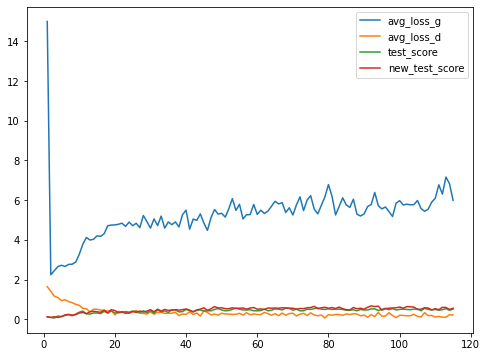

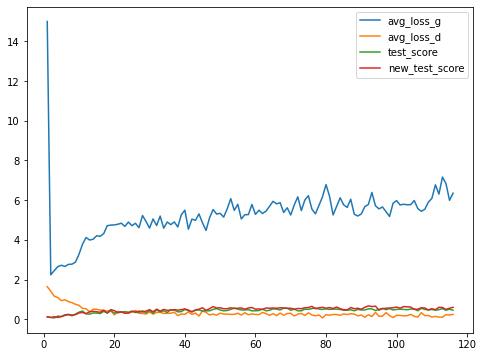

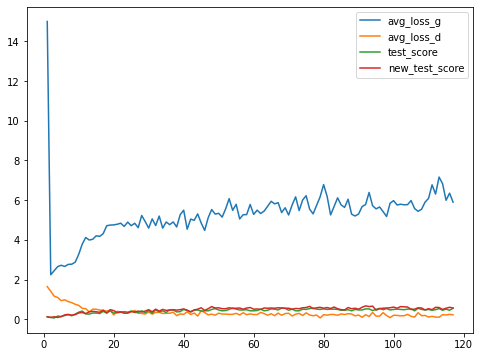

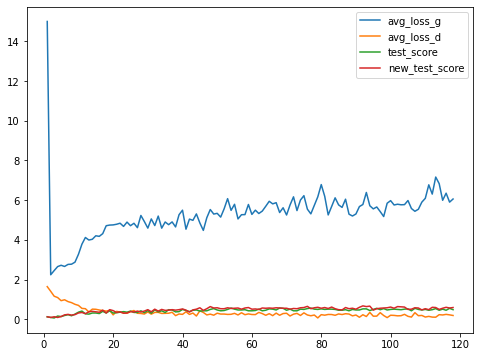

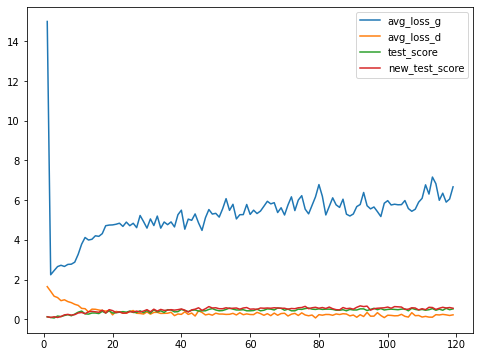

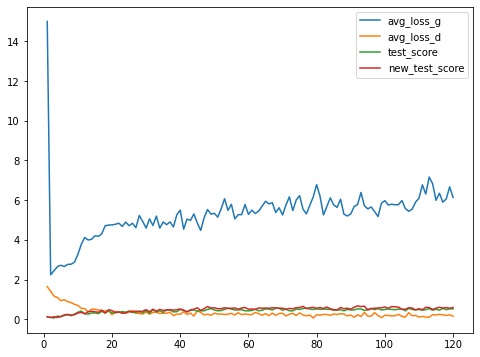

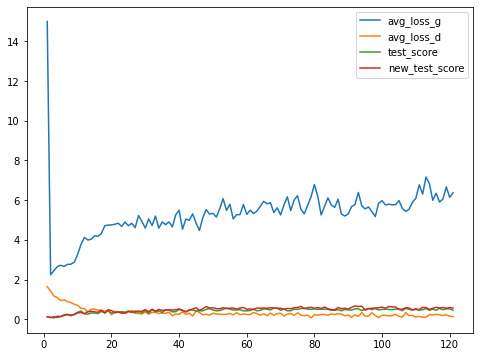

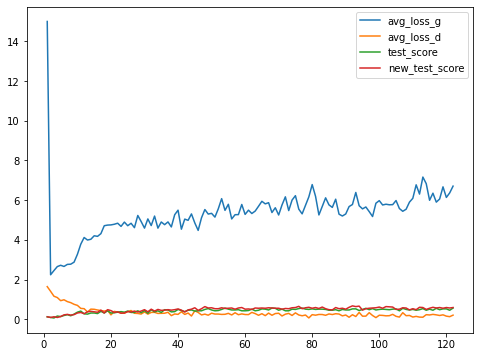

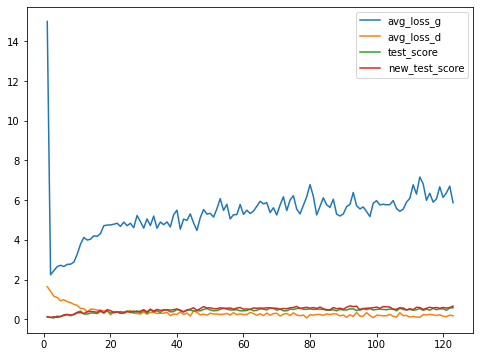

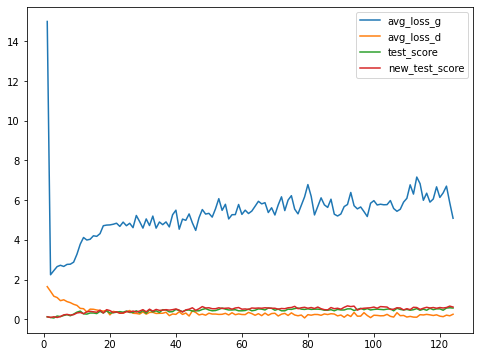

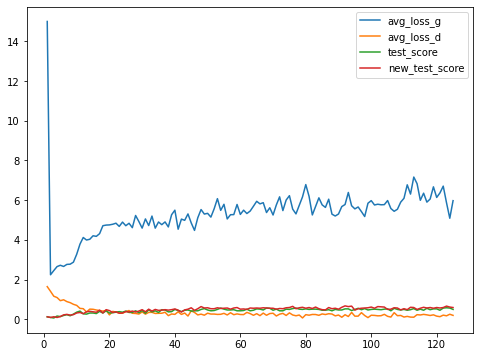

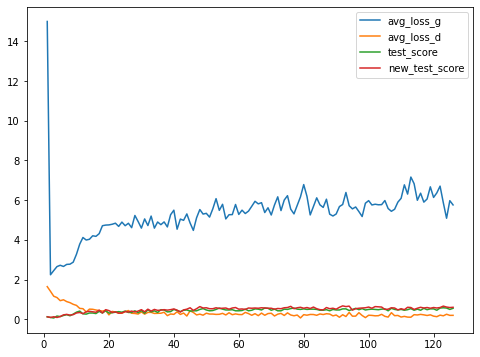

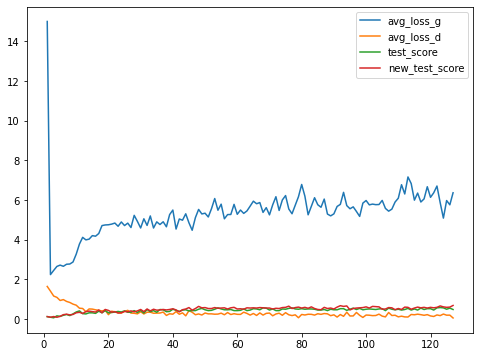

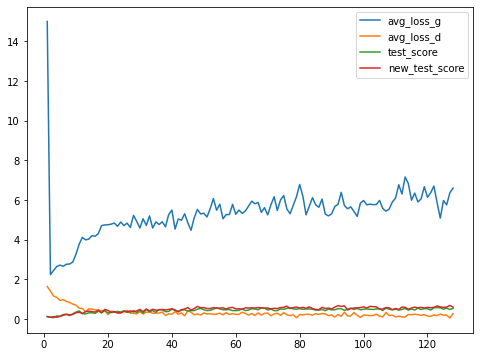

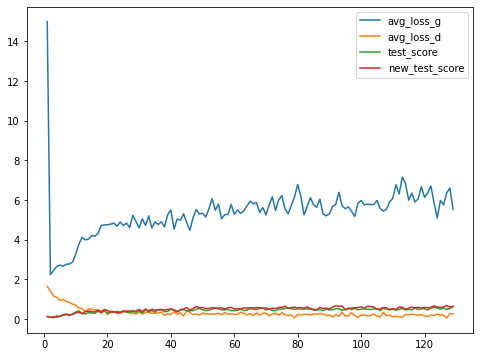

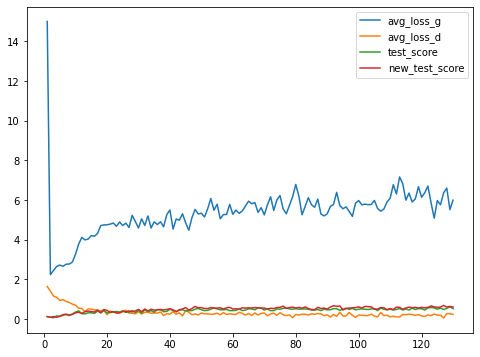

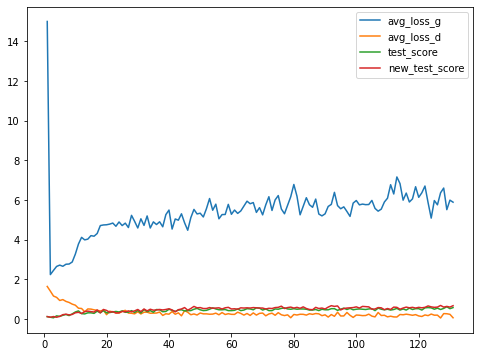

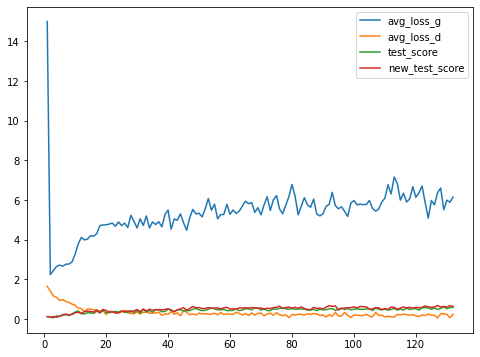

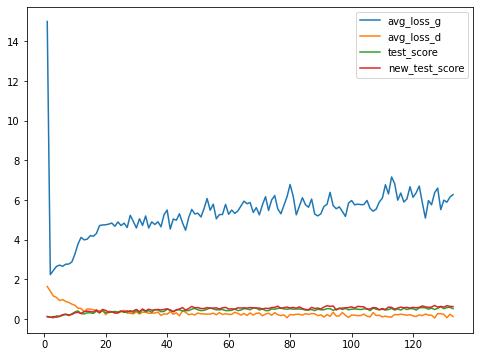

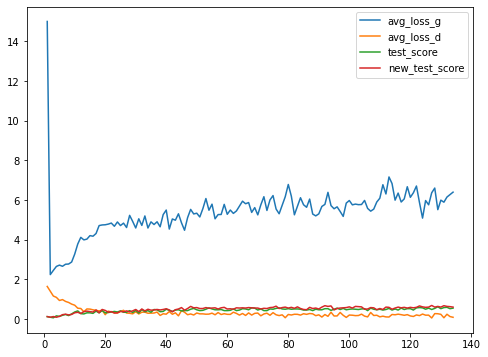

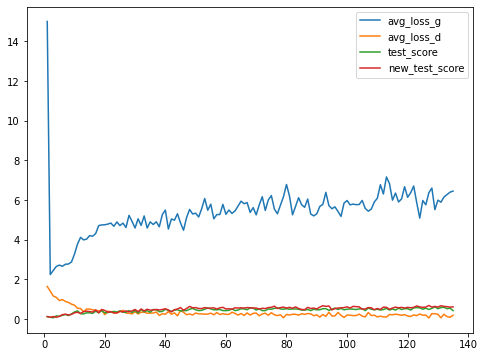

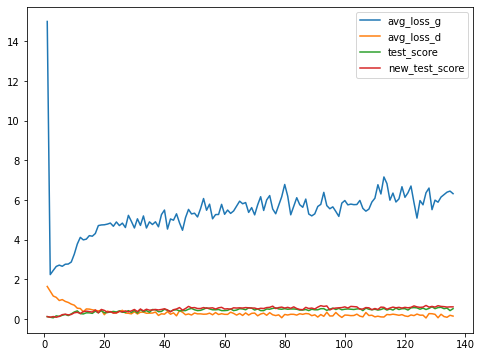

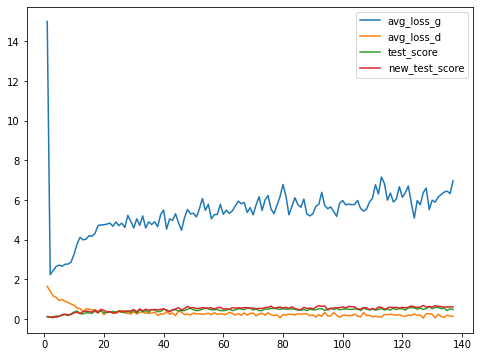

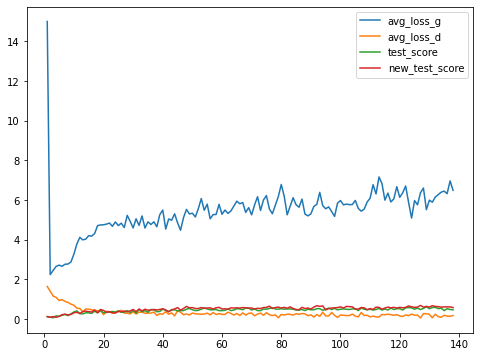

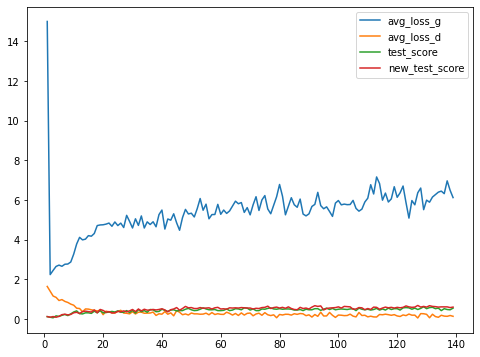

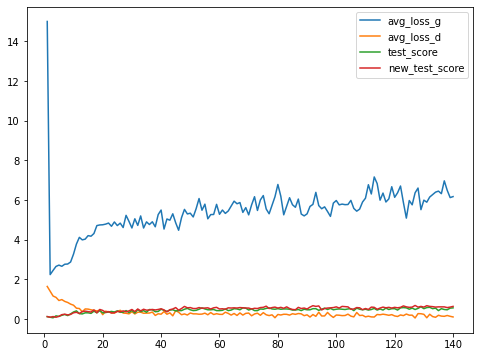

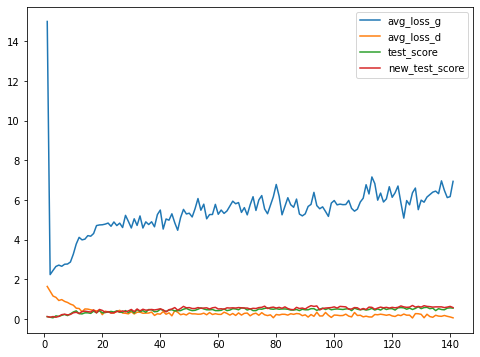

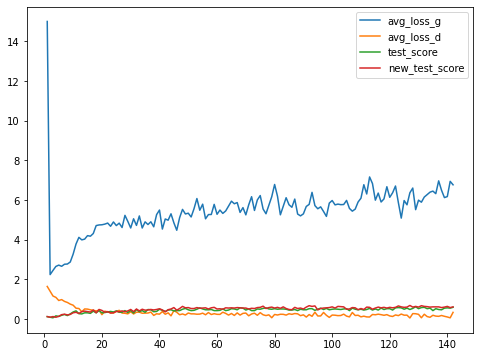

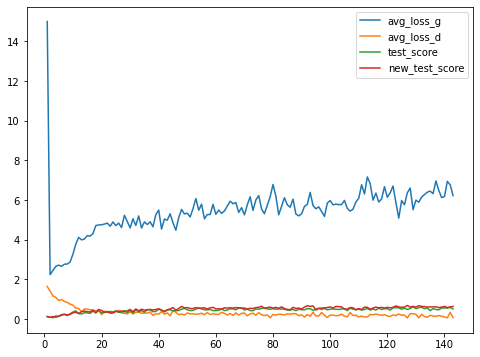

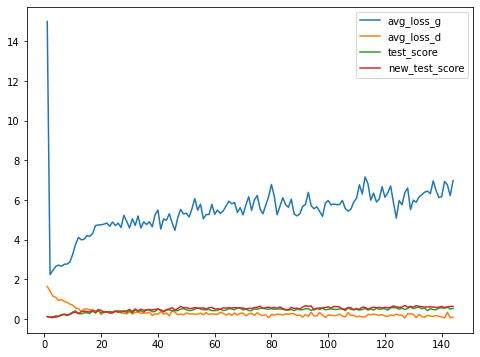

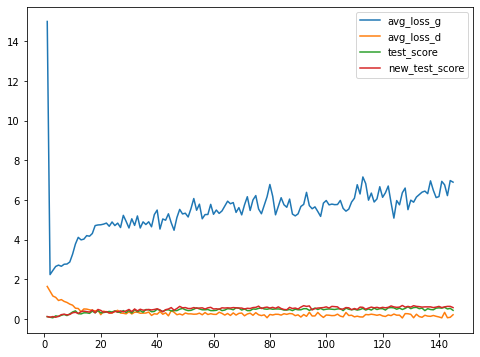

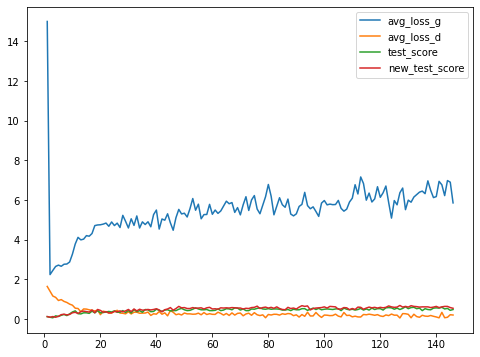

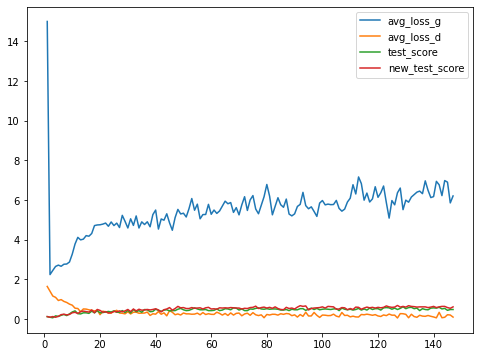

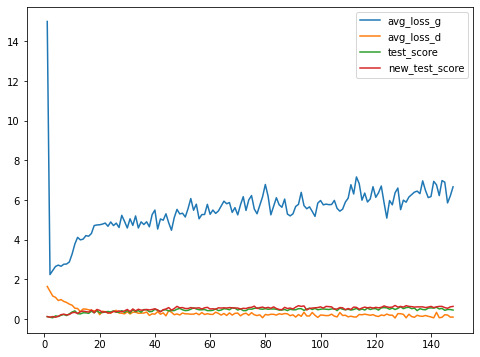

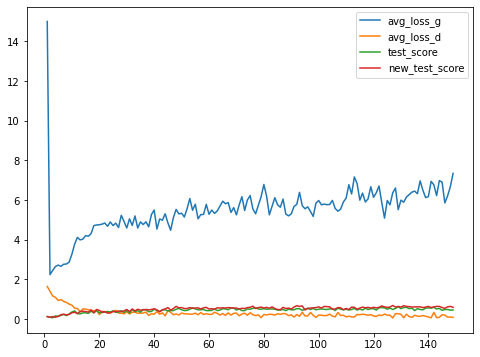

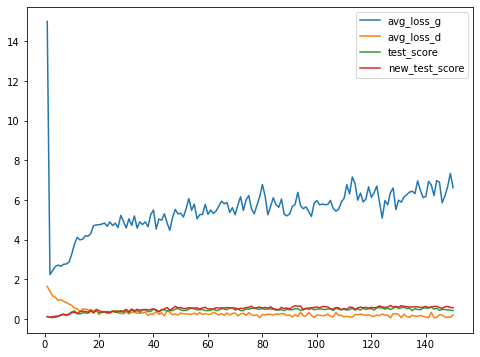

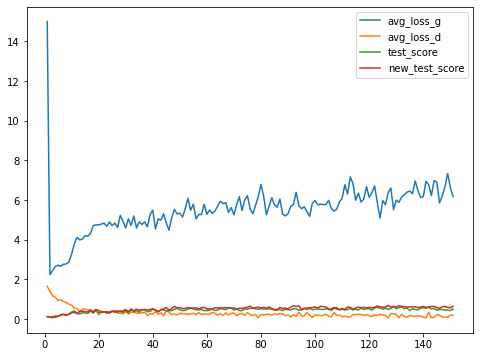

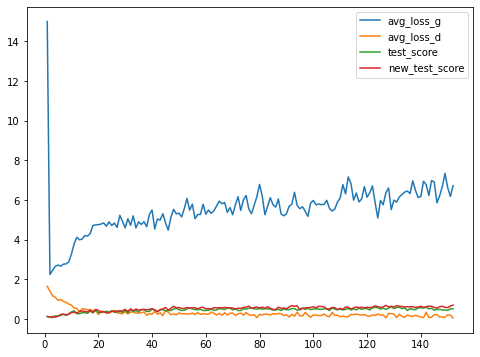

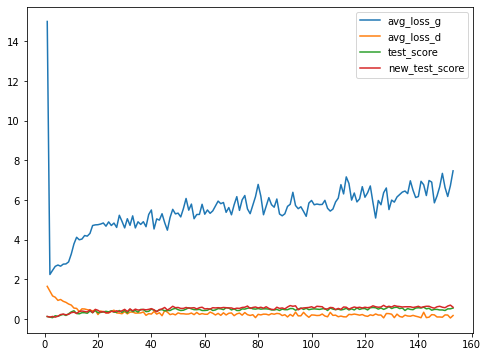

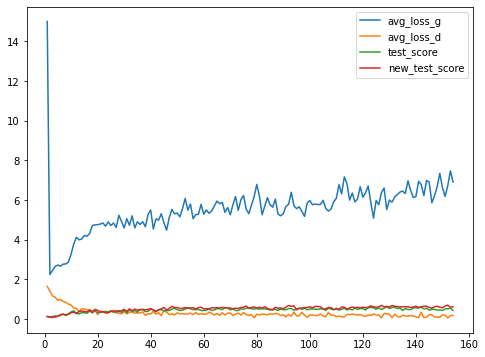

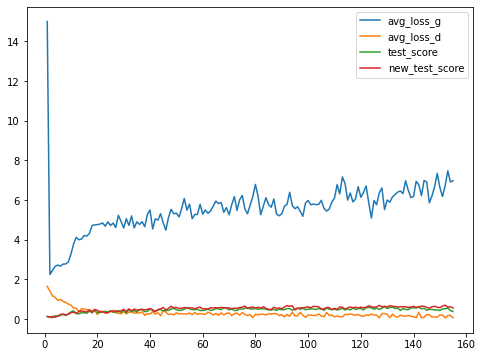

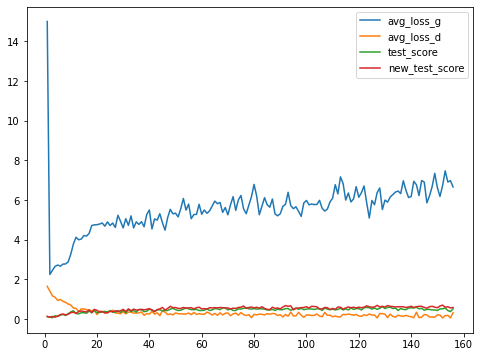

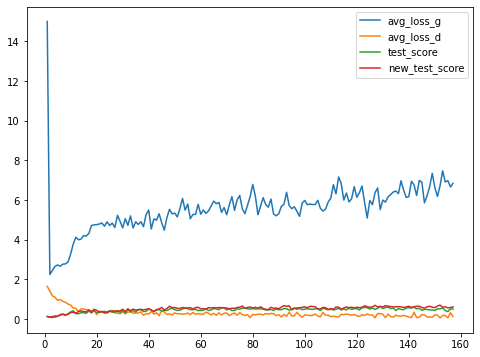

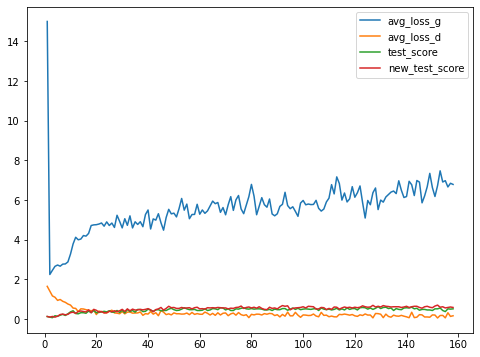

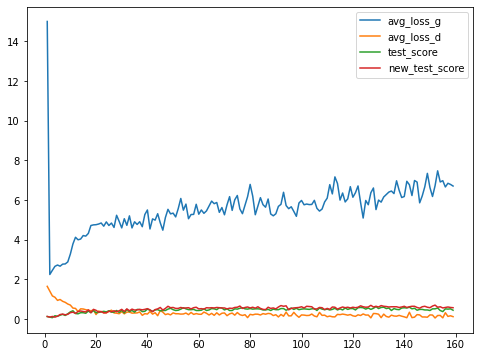

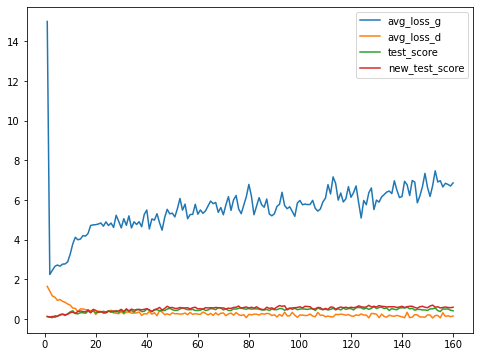

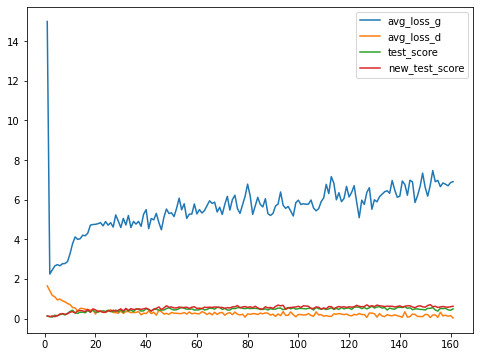

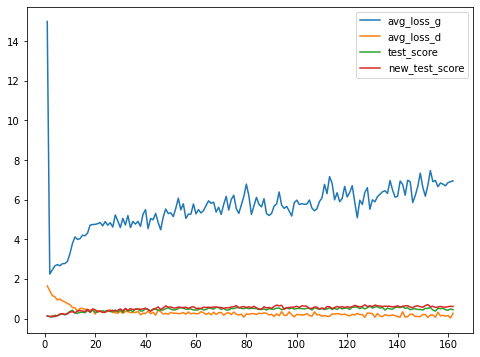

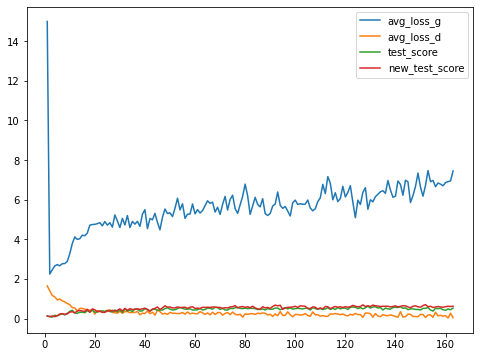

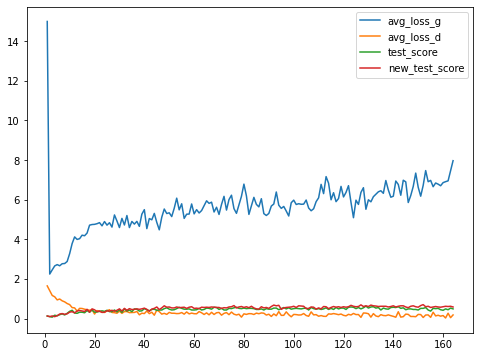

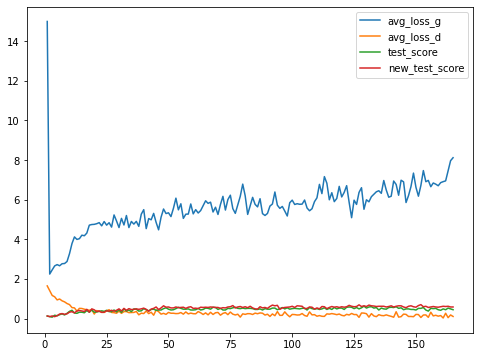

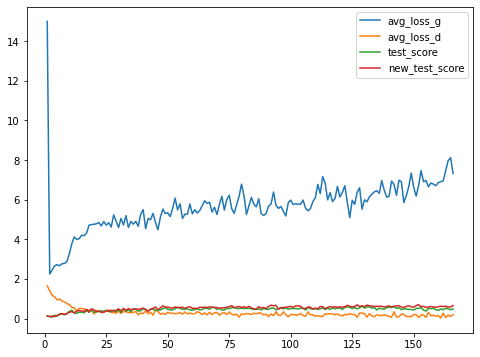

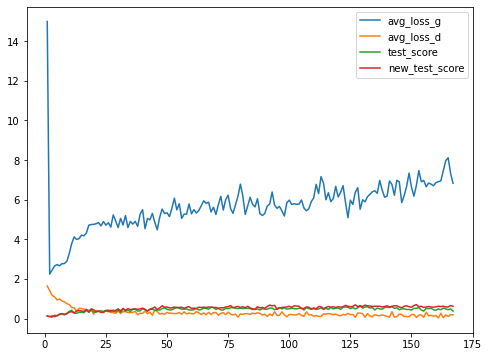

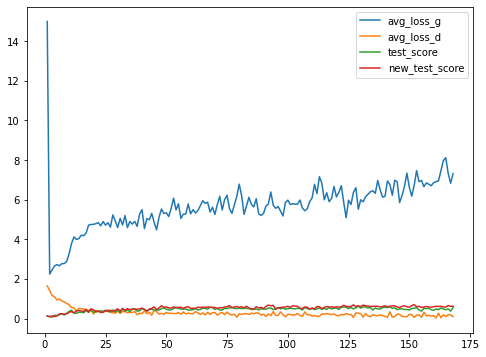

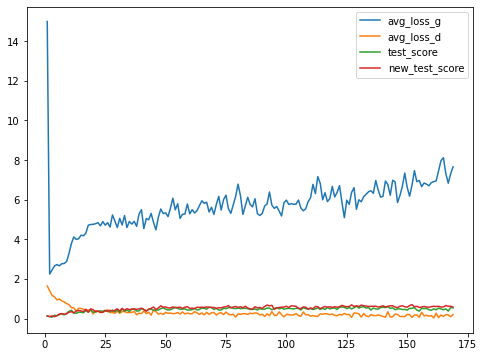

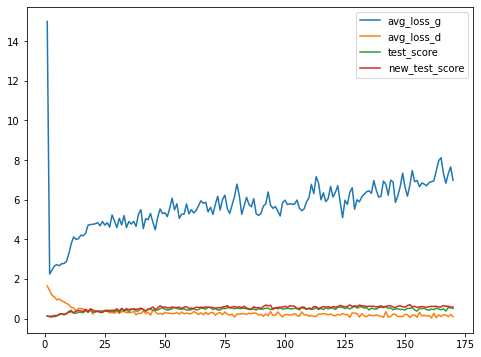

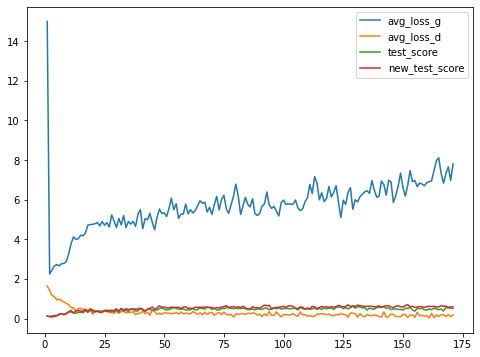

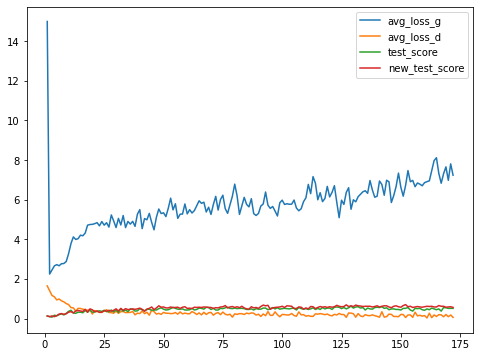

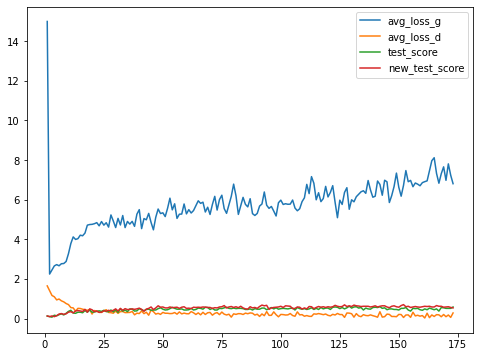

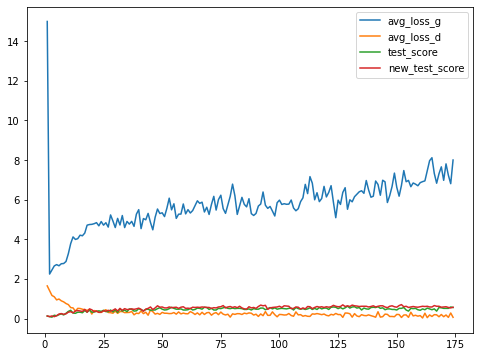

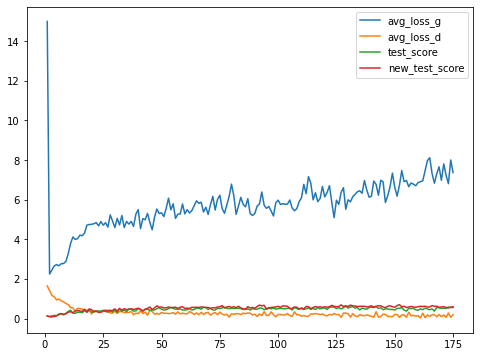

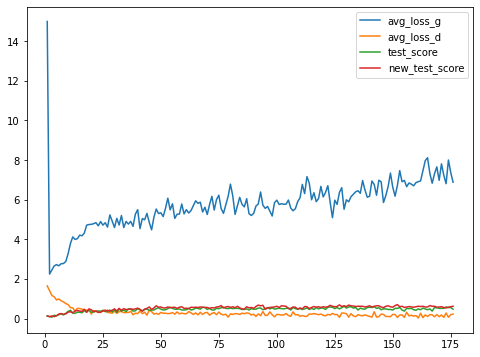

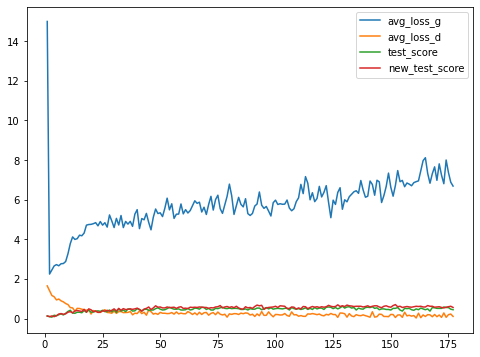

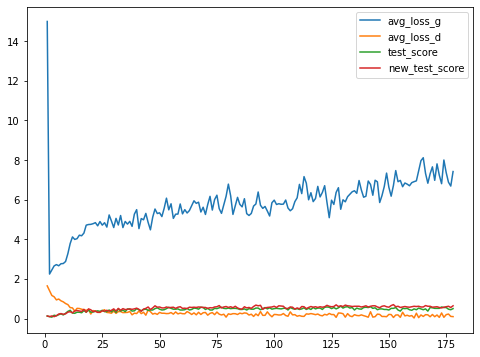

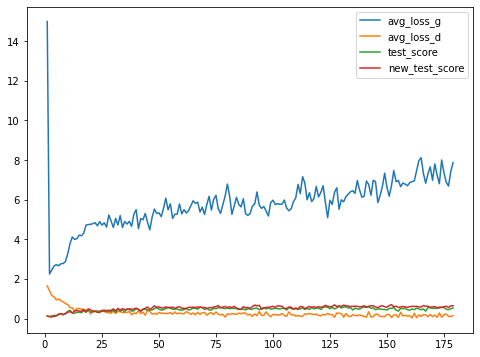

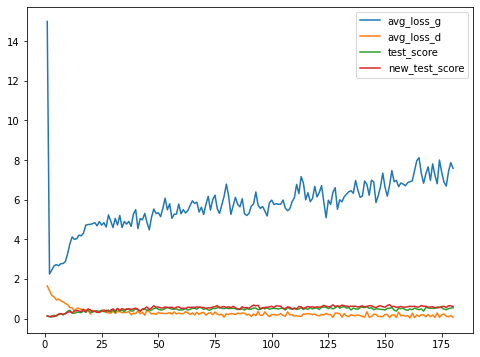

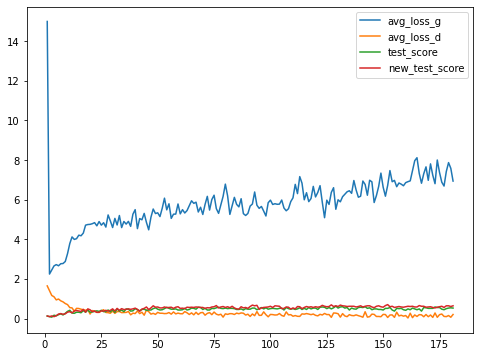

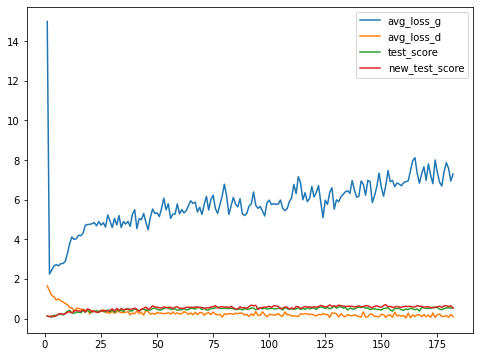

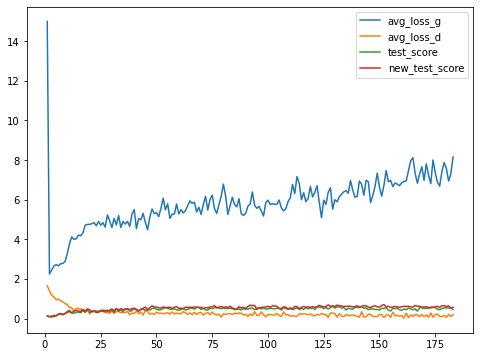

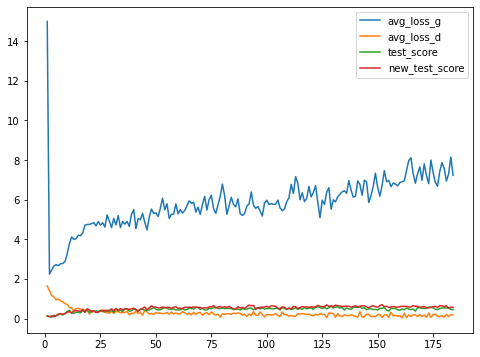

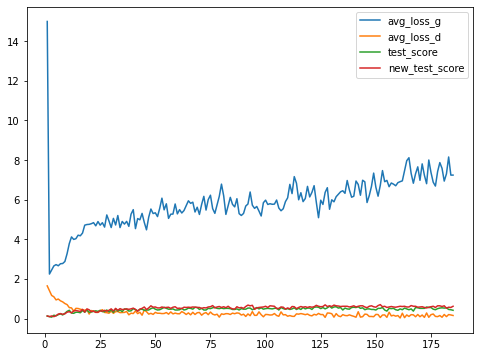

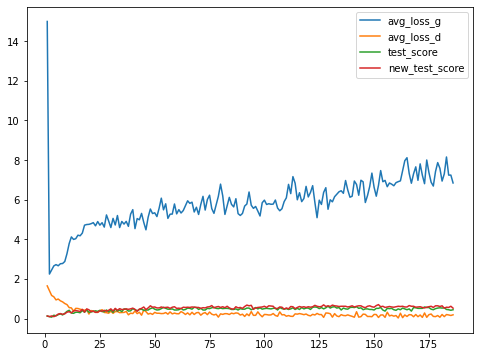

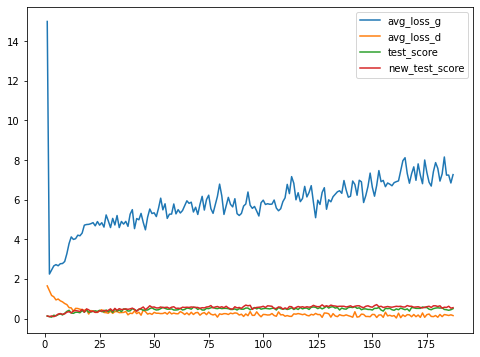

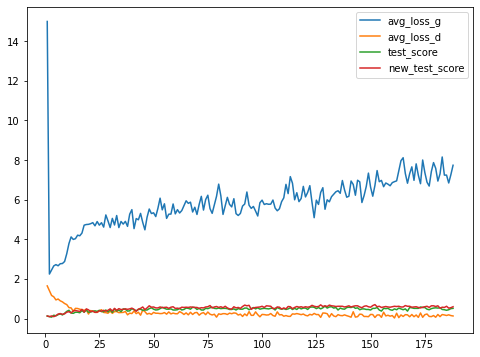

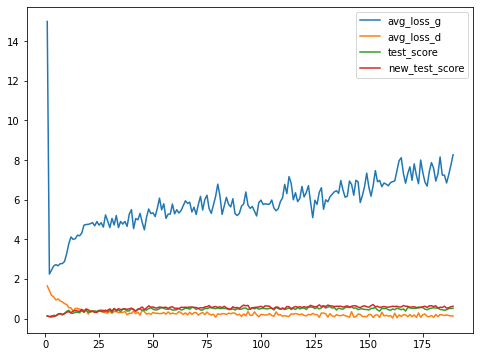

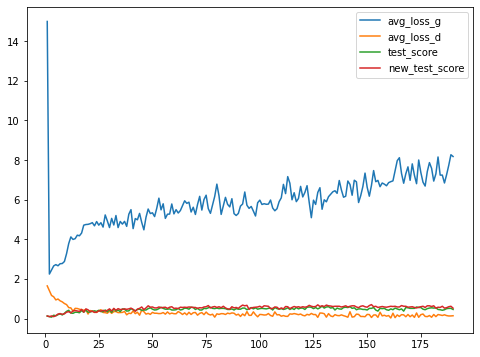

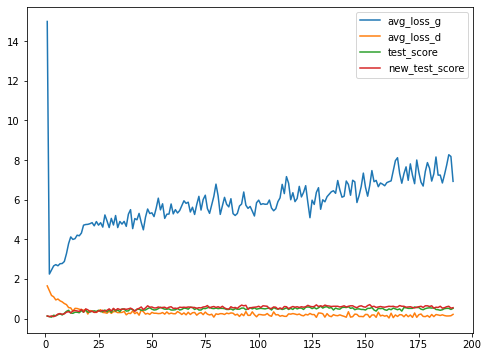

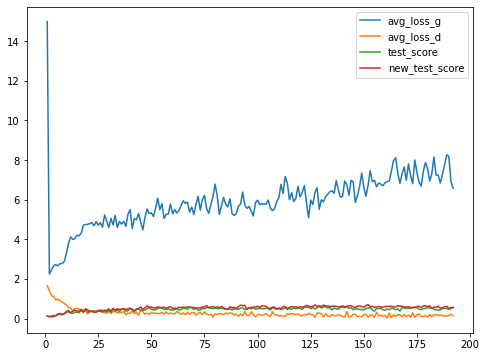

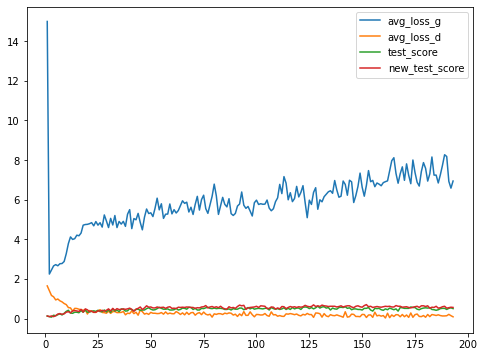

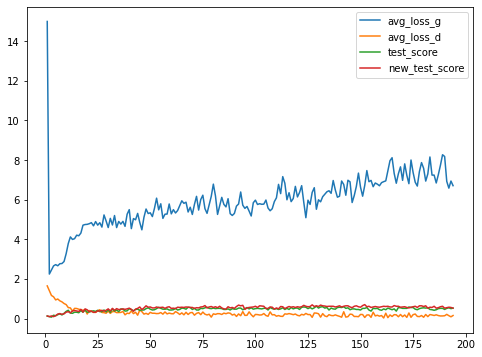

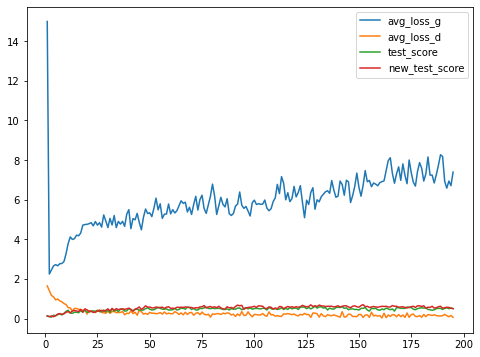

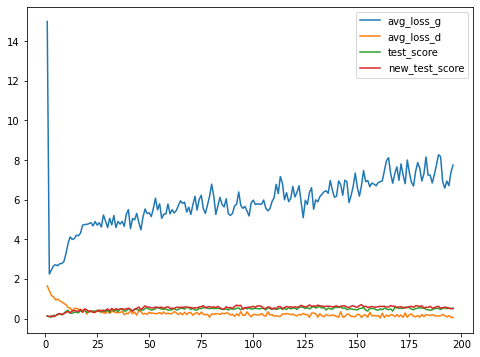

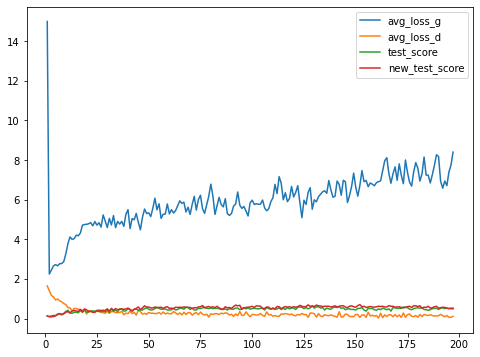

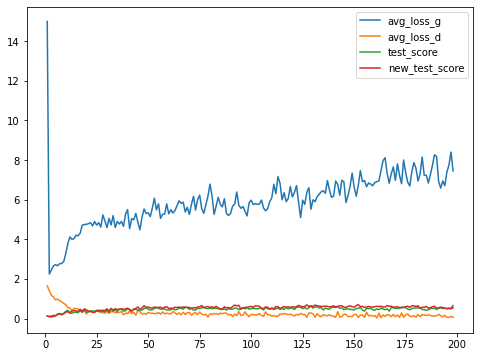

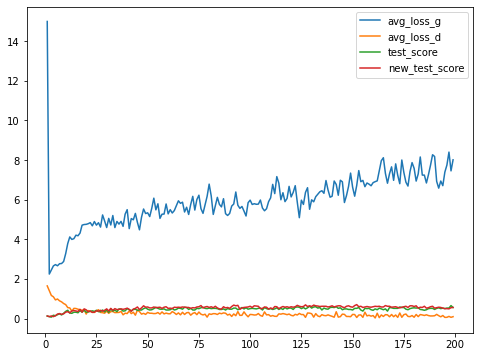

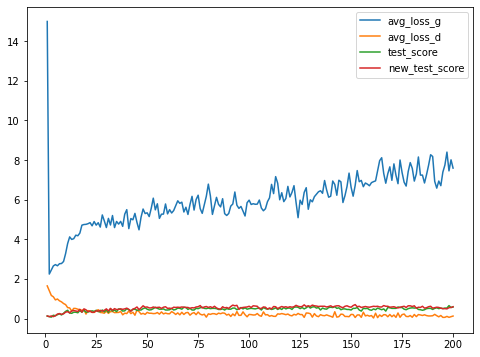

In [1]:
from dataset import ICLEVRLoader
from model import Discriminator, Generator
from evaluator import evaluation_model,plot
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt
import pathlib
import torch
import torch.nn as nn
import numpy as np
import copy
import os 

if __name__=='__main__':

    #create dir
    if not os.path.exists("./results"):
        os.makedirs("./results")
        
    if not os.path.exists("./ckpt"):
        os.makedirs("./ckpt")
        
    if not os.path.exists("./plots"):
        os.makedirs("./plots")
        
    # setting parameters
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    z_dim=100
    c_dim=200
    image_shape=(3,64,64)
    epochs=200
    lr=0.0002
    batch_size=128
    
    # load training data
    root_folder=pathlib.Path().absolute()
    data_train = ICLEVRLoader(root_folder,mode="train")
    loader_train = DataLoader(data_train,batch_size=batch_size,shuffle=True,num_workers=16)
    
    # create generate & discriminator
    generator=Generator(z_dim,c_dim).to(device)
    discrimiator=Discriminator(image_shape,c_dim).to(device)
    generator.weight_init(mean=0,std=0.02)
    discrimiator.weight_init(mean=0,std=0.02)

    #training
    Criterion=nn.BCELoss()
    optimizer_g=torch.optim.Adam(generator.parameters(),lr,betas=(0.5,0.99))
    optimizer_d=torch.optim.Adam(discrimiator.parameters(),lr,betas=(0.5,0.99))
    
    evaluation_model=evaluation_model()
    
    test_labels = ICLEVRLoader(root_folder,mode="test")
    test_conditions = np.zeros((len(test_labels),24))
    for i in range(len(test_labels)):
        test_conditions[i] = test_labels[i]
    test_conditions = torch.from_numpy(test_conditions).float().to(device)
    
    new_test_labels = ICLEVRLoader(root_folder,mode="new_test")
    new_test_conditions = np.zeros((len(new_test_labels),24))
    for i in range(len(new_test_labels)):
        new_test_conditions[i] = new_test_labels[i]
    new_test_conditions = torch.from_numpy(new_test_conditions).float().to(device)
    
    avg_loss_g_list, avg_loss_d_list,test_score_list,new_test_score_list = [],[],[],[]
    fixed_z = torch.randn((len(test_labels), z_dim)).to(device)
    best_test_score = 0
    best_new_test_score = 0
    for epoch in range (1,1+epochs):
        total_loss_g=0
        total_loss_d=0
        for i,(images,conditions) in enumerate(loader_train):
            generator.train()
            discrimiator.train()
            images = images.to(device)
            conditions = conditions.float().to(device)
            
            """
            train discrimiator
            """
            optimizer_d.zero_grad()
            
            #real images
            predicts = discrimiator(images, conditions)
            real = torch.ones(len(predicts)).to(device)
            loss_real = Criterion(predicts, real)
            #fake images
            z = torch.randn(len(predicts), z_dim).to(device)
            fake = torch.zeros(len(predicts)).to(device)

            gen_imgs = generator(z, conditions)
            predicts = discrimiator(gen_imgs, conditions)
            loss_fake = Criterion(predicts, fake)
            #bp
            loss_d  = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()
            
            """
            train generator
            """
            for _ in range(2): # improve strength of generator

                optimizer_g.zero_grad()
                z = torch.randn(len(predicts), z_dim).to(device)
                gen_imgs = generator(z, conditions)
                predicts = discrimiator(gen_imgs, conditions)
                loss_g  = Criterion(predicts, real)
                #bp
                loss_g.backward()
                optimizer_g.step()
            
            total_loss_g+=loss_g.item()
            total_loss_d+=loss_d.item()
        
        # evaluate
        generator.eval()
        
        with torch.no_grad():
            test_imgs=generator(fixed_z,test_conditions)
            new_test_imgs=generator(fixed_z,new_test_conditions)
            
        test_score=evaluation_model.eval(test_imgs,test_conditions)
        new_test_score=evaluation_model.eval(new_test_imgs,new_test_conditions)
        
        test_score_list.append(test_score)
        new_test_score_list.append(new_test_score)
        avg_loss_g_list.append(total_loss_g/len(loader_train))
        avg_loss_d_list.append(total_loss_d/len(loader_train))
        
        if test_score>best_test_score :
            best_test_score=test_score
            best_model=copy.deepcopy(generator.state_dict())
            torch.save(best_model,os.path.join('ckpt',f'epoch{epoch}_best_test_score{best_test_score:.2f}.pt'))
        
        if new_test_score>best_new_test_score :
            best_new_test_score=new_test_score
            best_model=copy.deepcopy(generator.state_dict())
            torch.save(best_model,os.path.join('ckpt',f'epoch{epoch}_best_new_test_score{best_new_test_score:.2f}.pt'))
        
        print(f'epoch{epoch}: avg loss_g: {total_loss_g/len(loader_train):.3f}  avg_loss_d: {total_loss_d/len(loader_train):.3f}')
        print(f'testing score: {test_score:.2f} best_test_score = {best_test_score:.2f}')
        print(f'new_testing score: {new_test_score:.2f} best_new_test_score={best_new_test_score:.2f}')
        print('---------------------------------------------')
        
        # savefig
        save_image(gen_imgs, os.path.join('results', f'epoch{epoch}.png'), nrow=8, normalize=True)
        fig=plot(epoch,avg_loss_g_list,avg_loss_d_list,test_score_list,new_test_score_list)
        fig.savefig(os.path.join('plots',f'plots.png'))